In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import requests

#Import & Scrapping
##Keys & dxy, gold scrapping
using AV and fredapi

In [ ]:
fred = '4c6126e875c9d02dfb10781331c01a2d'

In [ ]:
mahkey = 'IEQX4TDJPBO3FK0V'

In [ ]:
def get_gold_data_alpha(api_key):
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": "XAUUSD",
        "outputsize": "full",   # full history (sekitar 20 tahun kalau ada)
        "apikey": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()

    if "Time Series (Daily)" not in data:
        print("Error:", data)
        return None

    df = pd.DataFrame.from_dict(data["Time Series (Daily)"], orient="index")
    # df = df.rename(columns={
    #     "1. open": "open",
    #     "2. high": "high",
    #     "3. low": "low",
    #     "4. close": "close",
    #     "5. volume": "volume"
    # })
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # filter 5 tahun terakhir
    df = df.loc[df.index >= pd.Timestamp.today() - pd.DateOffset(years=5)]
    return df


In [ ]:
def get_dxy_from_fred(fed):
    """Ambil data DXY dari FRED API (5 tahun terakhir)"""
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": "DTWEXBGS",   # Dollar Index Broad Goods
        "api_key": fed,
        "file_type": "json",
        "frequency": "d",          # daily data
        "observation_start": (datetime.now() - timedelta(days=5*365)).strftime("%Y-%m-%d"),
        "observation_end": datetime.now().strftime("%Y-%m-%d")
    }

    response = requests.get(url, params=params)
    data = response.json()
    print(response.json())

    # parsing ke DataFrame
    dxy_data = []
    for obs in data["observations"]:
        dxy_data.append({
            "date": obs["date"],
            "value": None if obs["value"] == "." else float(obs["value"])
        })

    df = pd.DataFrame(dxy_data)
    df["date"] = pd.to_datetime(df["date"])
    # df = df.dropna().reset_index(drop=True)

    return df


In [ ]:
def get_vix_from_fred(fed):
    """Ambil data VIX dari FRED API (5 tahun terakhir)."""

    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": "VIXCLS",  # CBOE Volatility Index (Close)
        "api_key": fed,
        "file_type": "json",
        "frequency": "d",
        "observation_start": (datetime.now() - timedelta(days=5*365)).strftime("%Y-%m-%d"),
        "observation_end": datetime.now().strftime("%Y-%m-%d")
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Parsing ke DataFrame
    vix_list = []
    for obs in data["observations"]:
        vix_list.append({
            "date": obs["date"],
            "vix": None if obs["value"] == "." else float(obs["value"])
        })

    df_vix = pd.DataFrame(vix_list)
    df_vix["date"] = pd.to_datetime(df_vix["date"])

    return df_vix

In [ ]:
def get_fred_series(series_id, api_key, fif, start_years=5):
    """
    Download data FRED dalam format DataFrame
    """
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "frequency": fif,
        "observation_start": (datetime.now() - timedelta(days=start_years*365)).strftime("%Y-%m-%d"),
        "observation_end": datetime.now().strftime("%Y-%m-%d")
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Add error handling
    if "observations" not in data:
        print(f"Error: 'observations' key not found for series_id: {series_id}")
        print("Full API Response:")
        print(data)
        return None # Return None if data is not in the expected format

    rows = []
    for obs in data["observations"]:
        value = obs["value"]
        rows.append({
            "date": obs["date"],
            "value": None if value == "." else float(value)
        })

    df = pd.DataFrame(rows)
    df["date"] = pd.to_datetime(df["date"])
    df = df.dropna().reset_index(drop=True)

    return df

In [ ]:
df_cpi = get_fred_series("CPIAUCSL", fred, 'm' , start_years=5)
df_cpi.rename(columns={"value": "cpi"}, inplace=True)

if df_cpi is not None:
  display(df_cpi.head())

,date,value
0,2020-11-01,260.911
1,2020-12-01,262.045
2,2021-01-01,262.639
3,2021-02-01,263.573
4,2021-03-01,264.847


In [ ]:
df_cpi = df_cpi.set_index("date").resample("D").ffill().reset_index()

In [ ]:
df_dgs10 = get_fred_series("DGS10", fred, 'd' ,start_years=5)
df_dgs10.rename(columns={"value": "dgs10"}, inplace=True)

df_dgs10.head()

,date,dgs10
0,2020-11-16,0.91
1,2020-11-17,0.87
2,2020-11-18,0.88
3,2020-11-19,0.86
4,2020-11-20,0.83


In [ ]:
# Assuming 'fred' is your FRED API key variable
df_oil = get_fred_series("DCOILWTICO", fred, start_years=5)
if df_oil is not None:
  df_oil.rename(columns={"value": "oil_wti"}, inplace=True)
  display(df_oil.head())

,date,oil_wti
0,2020-11-16,41.14
1,2020-11-17,41.24
2,2020-11-18,41.64
3,2020-11-19,41.57
4,2020-11-20,41.99


In [ ]:
dxy_df = get_dxy_from_fred(fred)

{'realtime_start': '2025-11-14', 'realtime_end': '2025-11-14', 'observation_start': '2020-11-15', 'observation_end': '2025-11-14', 'units': 'lin', 'output_type': 1, 'file_type': 'json', 'order_by': 'observation_date', 'sort_order': 'asc', 'count': 1300, 'offset': 0, 'limit': 100000, 'observations': [{'realtime_start': '2025-11-14', 'realtime_end': '2025-11-14', 'date': '2020-11-16', 'value': '113.8356'}, {'realtime_start': '2025-11-14', 'realtime_end': '2025-11-14', 'date': '2020-11-17', 'value': '113.6864'}, {'realtime_start': '2025-11-14', 'realtime_end': '2025-11-14', 'date': '2020-11-18', 'value': '113.4645'}, {'realtime_start': '2025-11-14', 'realtime_end': '2025-11-14', 'date': '2020-11-19', 'value': '113.6982'}, {'realtime_start': '2025-11-14', 'realtime_end': '2025-11-14', 'date': '2020-11-20', 'value': '113.4932'}, {'realtime_start': '2025-11-14', 'realtime_end': '2025-11-14', 'date': '2020-11-23', 'value': '113.759'}, {'realtime_start': '2025-11-14', 'realtime_end': '2025-11-

In [ ]:
gold_df = get_gold_data_alpha(mahkey)

In [ ]:
gold_df

,1. open,2. high,3. low,4. close,5. volume
2021-02-08,1830.5300,1836.8300,1828.9650,1835.8700,0
2021-02-09,1837.1200,1848.5700,1832.3100,1836.4100,0
2021-02-10,1836.4000,1855.4200,1834.2200,1842.1850,0
2021-02-11,1842.1700,1842.2850,1821.3050,1826.8600,0
2021-02-12,1826.8450,1830.7900,1810.6700,1824.2550,0
...,...,...,...,...,...
2025-11-10,4011.9000,4122.7600,4011.2400,4120.0500,0
2025-11-11,4120.0600,4149.0500,4097.1600,4142.7200,0
2025-11-12,4142.7100,4211.7200,4098.9900,4191.1300,0
2025-11-13,4191.0500,4245.0600,4145.3100,4186.0350,0


In [ ]:
dxy_df

,date,value
0,2020-11-16,113.8356
1,2020-11-17,113.6864
2,2020-11-18,113.4645
3,2020-11-19,113.6982
4,2020-11-20,113.4932
...,...,...
1295,2025-11-03,121.8422
1296,2025-11-04,122.2066
1297,2025-11-05,122.2295
1298,2025-11-06,122.0788


In [ ]:
vix_df = get_vix_from_fred(fred)

In [ ]:
vix_df

,date,vix
0,2020-11-16,22.45
1,2020-11-17,22.71
2,2020-11-18,23.84
3,2020-11-19,23.11
4,2020-11-20,23.70
...,...,...
1298,2025-11-06,19.50
1299,2025-11-07,19.08
1300,2025-11-10,17.60
1301,2025-11-11,17.28


#Preprocessing
- rename columns
- merge gold+dxy data
- drop volume column

In [ ]:
gold_df_reset = gold_df.reset_index().rename(columns={'index': 'date'})
df = pd.merge(gold_df_reset, dxy_df, on="date")

In [ ]:
df = pd.merge(df, vix_df, on="date", how= 'left')

In [ ]:
df = pd.merge(df, df_dgs10, on="date", how= 'left')

In [ ]:
df = pd.merge(df, df_cpi, on="date", how= 'left')

In [ ]:
df = pd.merge(df, df_oil, on="date", how= 'left')

In [ ]:
df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"
    })

In [ ]:
df = df.drop('volume', axis=1)

In [ ]:
df.head()

,date,open,high,low,close,dxy,vix,dgs10,cpi,oil_wti
0,2021-02-08,1830.530,1836.830,1828.965,1835.870,112.0512,21.24,1.19,263.573,57.95
1,2021-02-09,1837.120,1848.570,1832.310,1836.410,111.7768,21.63,1.18,263.573,58.34
2,2021-02-10,1836.400,1855.420,1834.220,1842.185,111.5929,21.99,1.15,263.573,58.69
3,2021-02-11,1842.170,1842.285,1821.305,1826.860,111.5364,21.25,1.16,263.573,58.22
4,2021-02-12,1826.845,1830.790,1810.670,1824.255,111.4981,19.97,1.20,263.573,59.50


#Data Cleaning

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')  # urutin tanggal
df.set_index('date', inplace=True)

In [ ]:
print(df.isnull().sum())

date       0
open       0
high       0
low        0
close      0
dxy        0
vix        0
dgs10      0
cpi        0
oil_wti    0
dtype: int64


In [ ]:
df = df.apply(pd.to_numeric, errors='coerce')

In [ ]:
df = df.ffill() # isi dengan data sebelumnya
# df = df.fillna(method='ffill')  # isi dengan data sebelumnya

In [ ]:
df = df.bfill() # isi dengan data sesudahnya untuk kolom pertama

In [ ]:
print(df.isnull().sum())

open       0
high       0
low        0
close      0
dxy        0
vix        0
dgs10      0
cpi        0
oil_wti    0
dtype: int64


In [ ]:
df = df[~df.index.duplicated(keep='first')]



---



In [ ]:
df.to_csv('my_dataframe.csv')

In [ ]:
df.to_csv('/content/drive/MyDrive/my_dataframe2.csv')

In [ ]:
df.to_csv('/content/drive/MyDrive/my_dataframe3.csv')

#File Hasil Scrapping 5 Tahun

File gold+dxy

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/my_dataframe.csv')

In [ ]:
df = df.rename(columns={'value':'dxy'})

gold+dxy+vix

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/my_dataframe2.csv')

gold + makro

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/my_dataframe3.csv')

In [ ]:
df

,date,open,high,low,close,dxy
0,2020-09-25,1869.16,1875.22,1852.40,1861.74,117.8786
1,2020-09-28,1862.33,1883.72,1848.56,1882.85,117.6290
2,2020-09-29,1882.52,1899.40,1875.57,1897.06,117.5379
3,2020-09-30,1896.64,1902.38,1881.49,1888.34,116.9570
4,2020-10-01,1888.00,1912.05,1884.77,1903.54,116.7339
...,...,...,...,...,...,...
1203,2025-09-15,3638.28,3685.65,3626.75,3677.00,120.0042
1204,2025-09-16,3676.95,3703.26,3674.76,3694.31,119.5860
1205,2025-09-17,3694.32,3707.64,3646.25,3669.24,119.6063
1206,2025-09-18,3669.34,3673.08,3627.99,3640.32,120.0986


#EDA

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')  # urutin tanggal
# df.set_index('date', inplace=True)

In [ ]:
# pastikan data terurut
df = df.sort_values("date").reset_index(drop=False)

In [ ]:
# ==== 1. Info dasar dataset ====
print("=== Info Dataset ===")
print(df.info())
print("\n=== Statistik Deskriptif ===")
print(df.describe())

=== Info Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1208 non-null   object 
 1   open    1208 non-null   float64
 2   high    1208 non-null   float64
 3   low     1208 non-null   float64
 4   close   1208 non-null   float64
 5   dxy     1208 non-null   float64
dtypes: float64(5), object(1)
memory usage: 56.8+ KB
None

=== Statistik Deskriptif ===
              open         high          low        close          dxy
count  1208.000000  1208.000000  1208.000000  1208.000000  1208.000000
mean   2170.786821  2186.022815  2156.235654  2172.314404   120.224055
std     510.484421   515.802392   505.815722   512.263698     4.547423
min    1624.940000  1640.985000  1614.880000  1627.730000   110.517900
25%    1809.786250  1819.222500  1798.522500  1809.688750   116.647175
50%    1941.140000  1953.925000  1929.650000  1941.995000   120

In [ ]:
# ==== 2. Missing value check ====
print("\n=== Missing Value ===")
print(df.isnull().sum())


=== Missing Value ===
date     0
open     0
high     0
low      0
close    0
dxy      0
dtype: int64


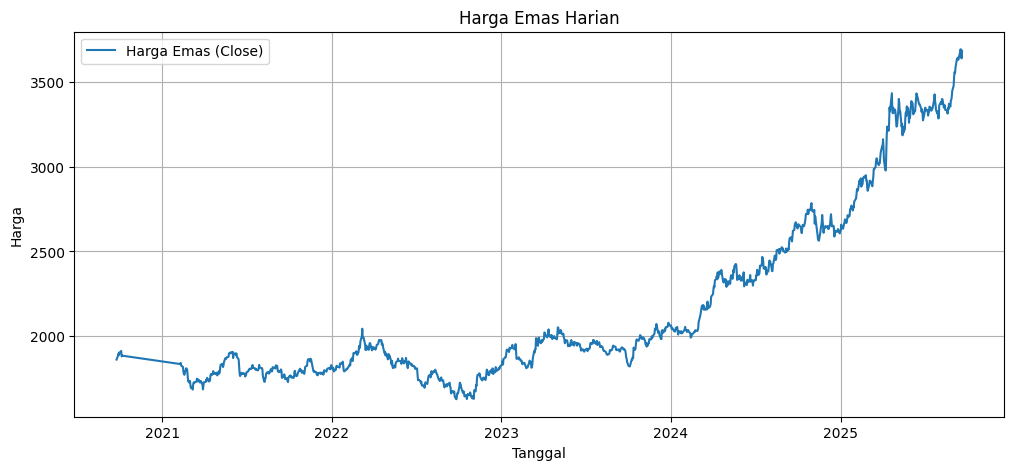

In [ ]:
# ==== 3. Plot harga emas ====
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["close"], label="Harga Emas (Close)")
plt.title("Harga Emas Harian")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

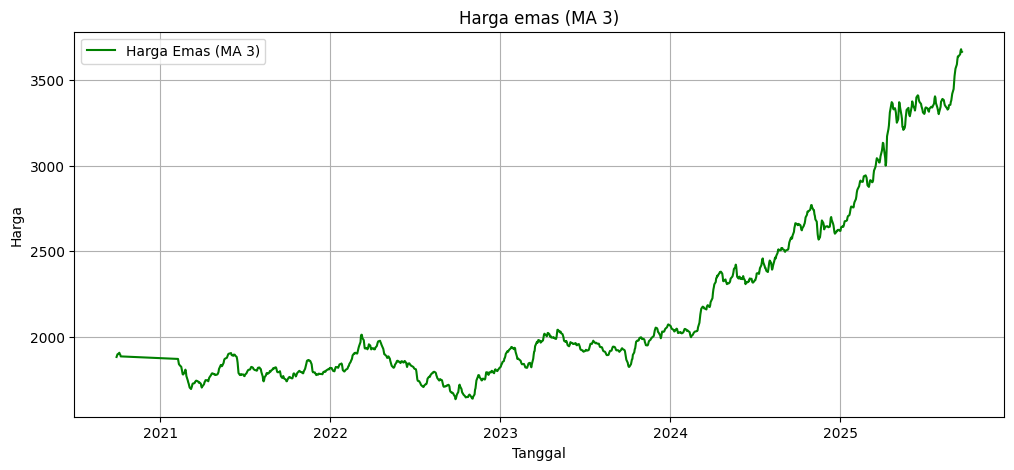

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["ma3"], label="Harga Emas (MA 3)", color="green")
# plt.plot(df["date"], df["close"], label="Harga Emas(Close)")
# plt.plot(df["date"], df["delta_ma3"], label="Indeks DXY", color="blue")
plt.title("Harga emas (MA 3)")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

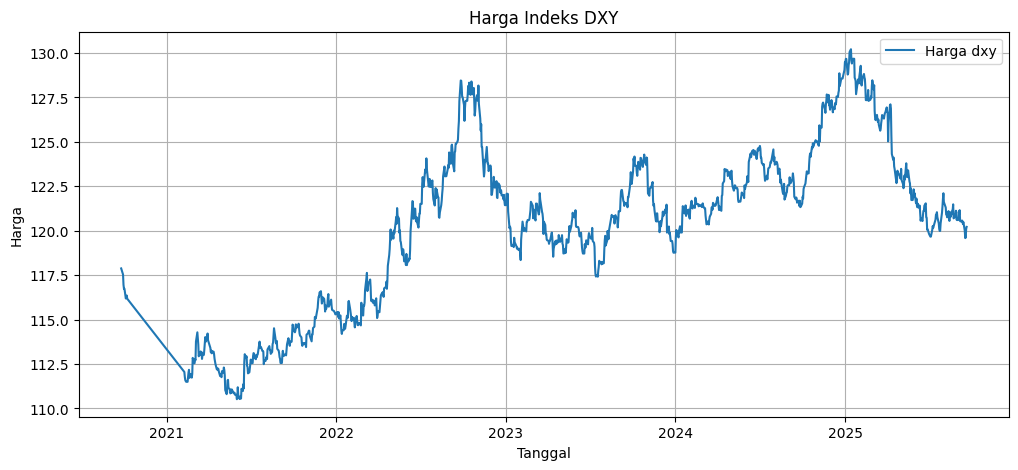

In [ ]:
# ==== 3. Plot harga dxy ====
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["dxy"], label="Harga dxy")
plt.title("Harga Indeks DXY")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

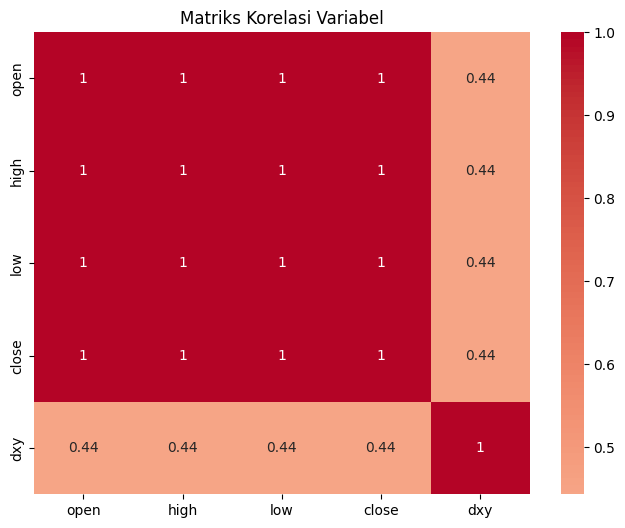

In [ ]:
# ==== 5. Korelasi antar variabel ====
plt.figure(figsize=(8,6))
corr = df[["open","high","low","close","dxy"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriks Korelasi Variabel")
plt.show()

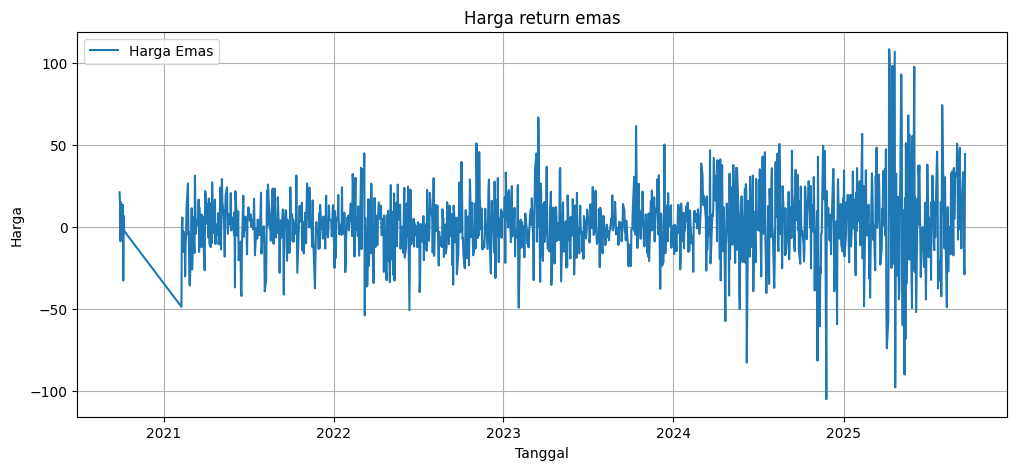

In [ ]:
df['close_diff'] = df['close'].diff()
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["close_diff"], label="Harga Emas")
plt.title("Harga return emas")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

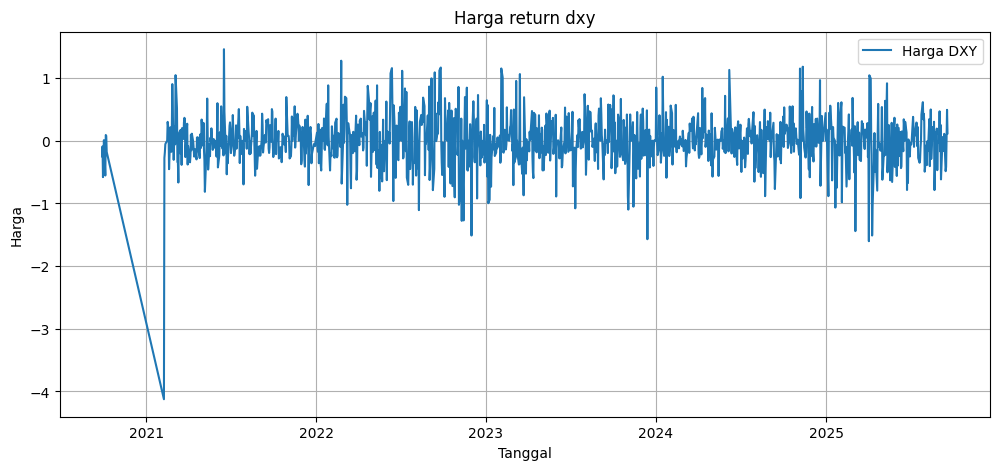

In [ ]:
df['dxy_diff'] = df['dxy'].diff()
plt.figure(figsize=(12,5))
plt.plot(df["date"], df['dxy_diff'], label="Harga DXY")
plt.title("Harga return dxy")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

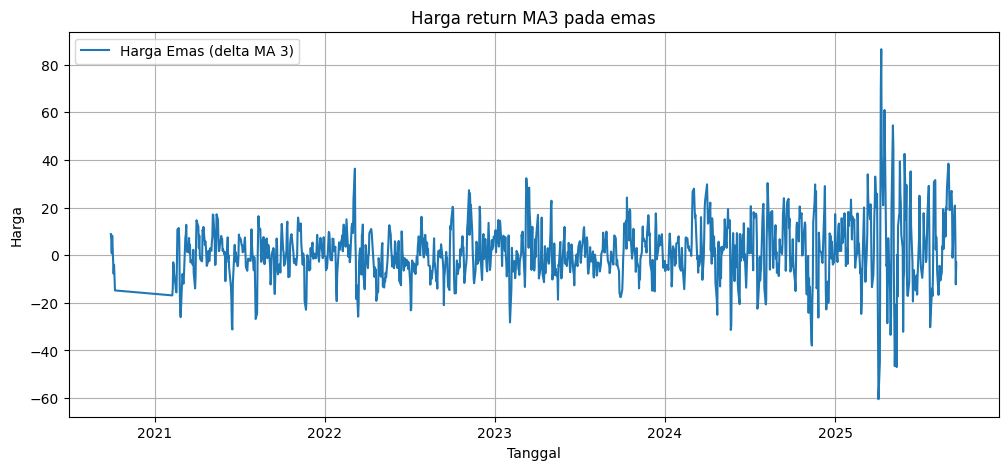

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["delta_ma3"], label="Harga Emas (delta MA 3)")
plt.title("Harga return MA3 pada emas")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

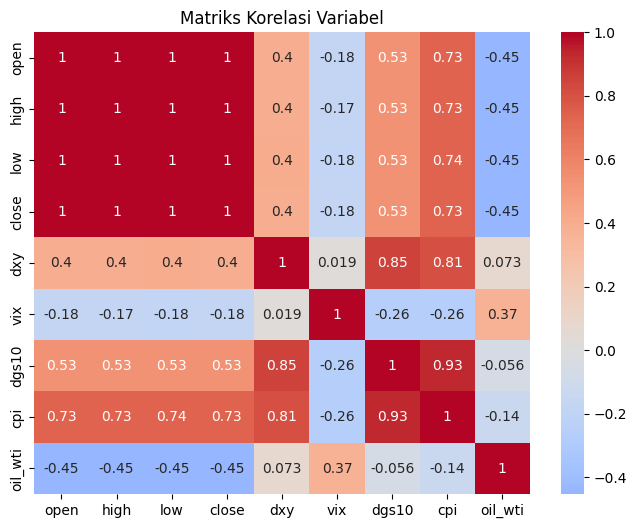

In [ ]:
# ==== 5. Korelasi antar variabel ====
plt.figure(figsize=(8,6))
corr = df[["open","high","low","close","dxy", 'vix', 'dgs10', 'cpi', 'oil_wti']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matriks Korelasi Variabel")
plt.show()

In [ ]:
df = df.drop('dgs10', axis=1)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# MA3
df['ma3'] = df['close'].rolling(window=3).mean()

# Target ΔMA3
df['delta_ma3'] = df['ma3'].shift(-1) - df['ma3']

# Lags (feel free to add/remove)
lags = [1, 3, 7, 14]

for lag in lags:
    df[f'close_lag{lag}'] = df['close'].shift(lag)
    df[f'ma3_lag{lag}'] = df['ma3'].shift(lag)


In [ ]:
df_uni = df[['close', 'ma3', 'delta_ma3'] +
            [f'close_lag{l}' for l in lags] +
            [f'ma3_lag{l}' for l in lags]].dropna()


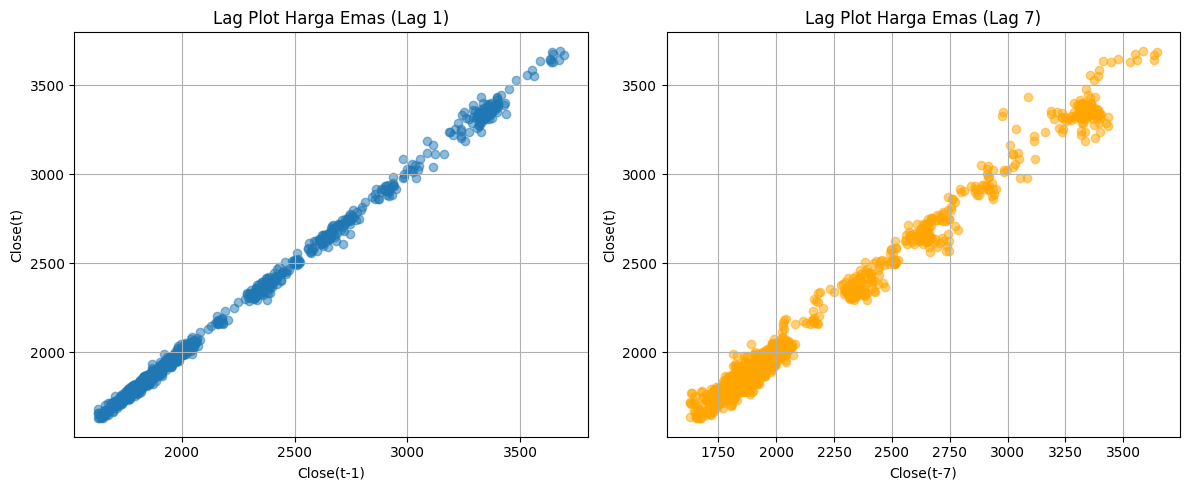

In [ ]:
# plot
plt.figure(figsize=(12,5))

# --- Lag 1 ---
plt.subplot(1,2,1)
plt.scatter(df['close_lag1'], df['close'], alpha=0.5)
plt.title("Lag Plot Harga Emas (Lag 1)")
plt.xlabel("Close(t-1)")
plt.ylabel("Close(t)")
plt.grid(True)

# --- Lag 7 ---
plt.subplot(1,2,2)
plt.scatter(df['close_lag7'], df['close'], alpha=0.5, color='orange')
plt.title("Lag Plot Harga Emas (Lag 7)")
plt.xlabel("Close(t-7)")
plt.ylabel("Close(t)")
plt.grid(True)

plt.tight_layout()
plt.show()

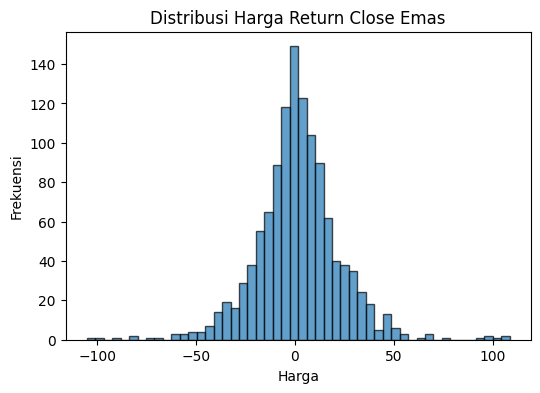

In [ ]:
# ==== 4. Distribusi harga emas ====
plt.figure(figsize=(6,4))
# df["close_diff"] = df["close"].diff()
plt.hist(df["close_diff"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribusi Harga Return Close Emas")
plt.xlabel("Harga"); plt.ylabel("Frekuensi")
plt.show()

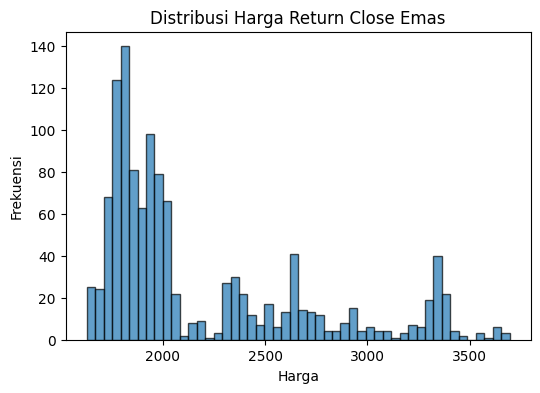

In [ ]:
# ==== 4. Distribusi harga emas ====
plt.figure(figsize=(6,4))
# df["close_diff"] = df["close"].diff()
plt.hist(df["close"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribusi Harga Return Close Emas")
plt.xlabel("Harga"); plt.ylabel("Frekuensi")
plt.show()

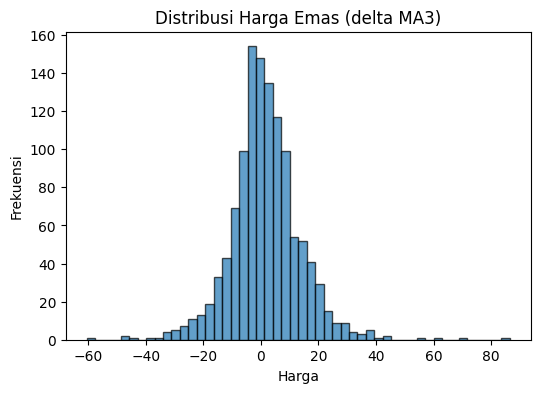

In [ ]:
# ==== 4. Distribusi harga emas ====
plt.figure(figsize=(6,4))
plt.hist(df["delta_ma3"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribusi Harga Emas (delta MA3)")
plt.xlabel("Harga"); plt.ylabel("Frekuensi")
plt.show()

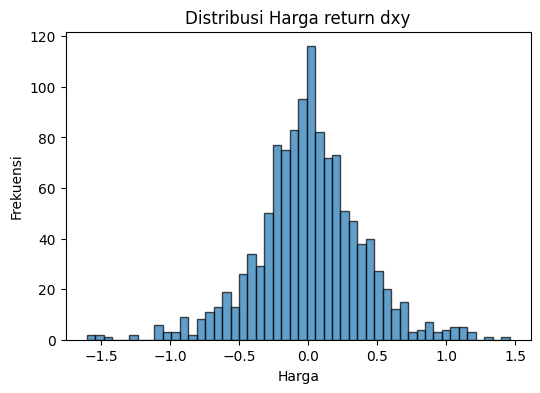

In [ ]:
# ==== 4. Distribusi harga emas ====
plt.figure(figsize=(6,4))
# df["dxy_diff"] = df["dxy"].diff()
plt.hist(df["dxy_diff"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribusi Harga return dxy")
plt.xlabel("Harga"); plt.ylabel("Frekuensi")
plt.show()

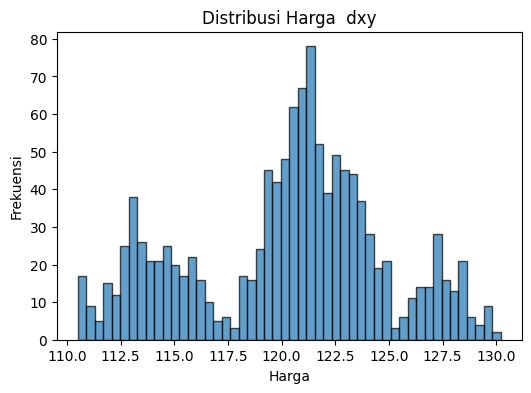

In [ ]:
# ==== 4. Distribusi harga emas ====
plt.figure(figsize=(6,4))
# df["dxy_diff"] = df["dxy"].diff()
plt.hist(df["dxy"], bins=50, edgecolor="k", alpha=0.7)
plt.title("Distribusi Harga  dxy")
plt.xlabel("Harga"); plt.ylabel("Frekuensi")
plt.show()

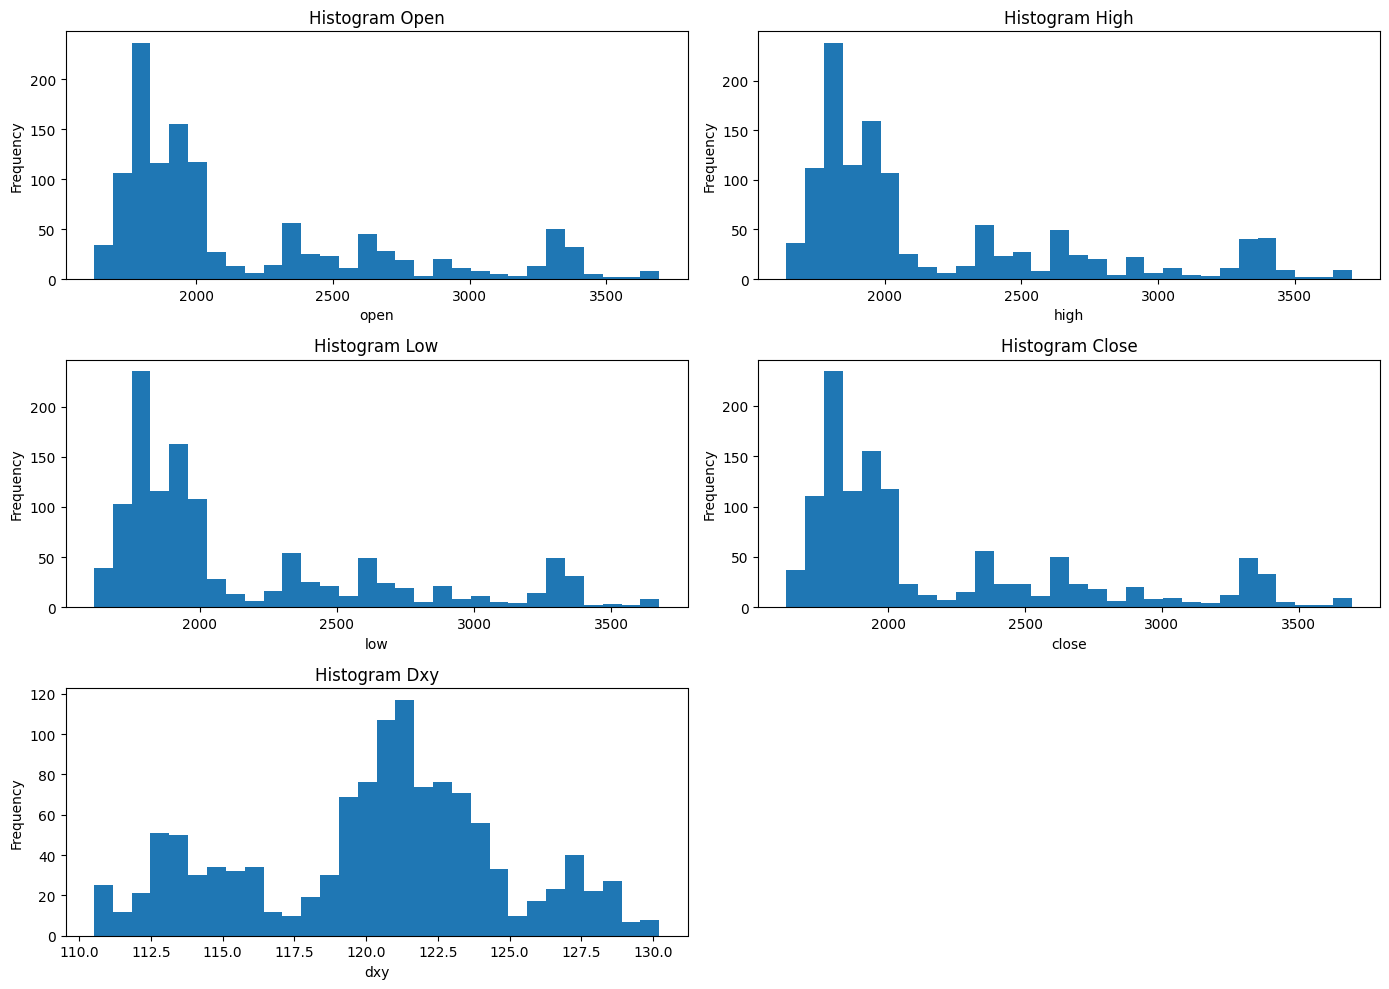

In [ ]:
cols = ["open", "high", "low", "close", "dxy"]

plt.figure(figsize=(14, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(3, 2, i)  # 3 baris, 2 kolom → cukup 5 subplot
    plt.hist(df[col], bins=30)
    plt.title(f"Histogram {col.capitalize()}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Matriks Korelasi Univariat (Close, MA3, ΔMA3, dan Lag)'}>

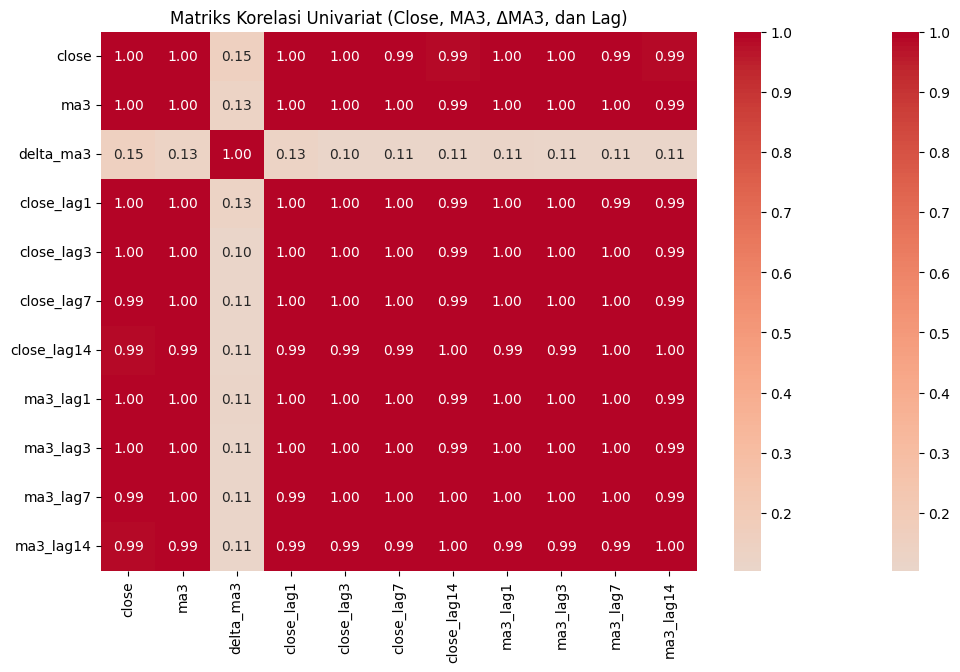

In [ ]:
plt.figure(figsize=(12, 7))
corr = df_uni.corr()

sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matriks Korelasi Univariat (Close, MA3, ΔMA3, dan Lag)")
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)


#Skenario 1
Model RF vs XGB

#Modelling
###Absolut

In [ ]:
#lag w shift
# Asumsikan 'df' adalah DataFrame awal Anda dengan kolom:
# 'date', 'open', 'high', 'low', 'close', 'dxy'
# Pastikan 'date' adalah index dan terurut
df = df.set_index('date').sort_index()

# LANGKAH 1: Buat Target Prediksi (Harga Close BESOK)
# Ini adalah langkah paling krusial. Kita geser kolom target ke atas.
df['target'] = df['close'].shift(-1)

# LANGKAH 2: Buat Fitur HANYA dari Data Masa Lalu (Lag)
# Kita buat fitur lag dari semua kolom yang relevan
feature_cols = ['open', 'high', 'low', 'close', 'dxy']
for col in feature_cols:
    for lag in [1, 3, 7]: # Anda bisa sesuaikan nilai lag
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# LANGKAH 3: Hapus Baris dengan Nilai Kosong (NaN)
# Ini akan menghapus beberapa baris di awal (karena lag) dan baris terakhir (karena target)
df.dropna(inplace=True)

# LANGKAH 4: Definisikan X dan y
# y adalah kolom 'target' yang sudah kita buat
y = df['target']
# X adalah semua kolom LAINNYA
X = df.drop(columns=['target', 'open', 'high', 'low', 'close', 'dxy'])

# LANGKAH 5: Lakukan Train-Test Split Kronologis
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Data siap untuk training!")
print("Contoh fitur di X_train:")
print(X_train.head())
print("\nContoh target di y_train:")
print(y_train.head())

Data siap untuk training!
Contoh fitur di X_train:
                    ma3  delta_ma3  close_lag1     ma3_lag1  close_lag3  \
date                                                                      
2021-02-16  1810.516667 -15.335000    1818.745  1823.286667    1826.860   
2021-02-17  1795.181667 -15.641667    1788.550  1810.516667    1824.255   
2021-02-18  1779.540000  -1.523333    1778.250  1795.181667    1818.745   
2021-02-19  1778.016667  10.781667    1771.820  1779.540000    1788.550   
2021-02-22  1788.798333  11.386667    1783.980  1778.016667    1778.250   

               ma3_lag3  close_lag7     ma3_lag7  close_lag14    ma3_lag14  \
date                                                                         
2021-02-16  1835.151667    1884.600  1883.976667      1897.06  1880.550000   
2021-02-17  1831.100000    1835.870  1869.176667      1888.34  1889.416667   
2021-02-18  1823.286667    1836.410  1852.293333      1903.54  1896.313333   
2021-02-19  1810.516667    1842.1

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def eval_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{dataset_name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

Train (Simple RF) -> MAE: 11.5246, RMSE: 15.7171, R²: 0.9955, MAPE: 0.59%
Test (Simple RF) -> MAE: 427.8124, RMSE: 528.8309, R²: -1.7140, MAPE: 13.01%


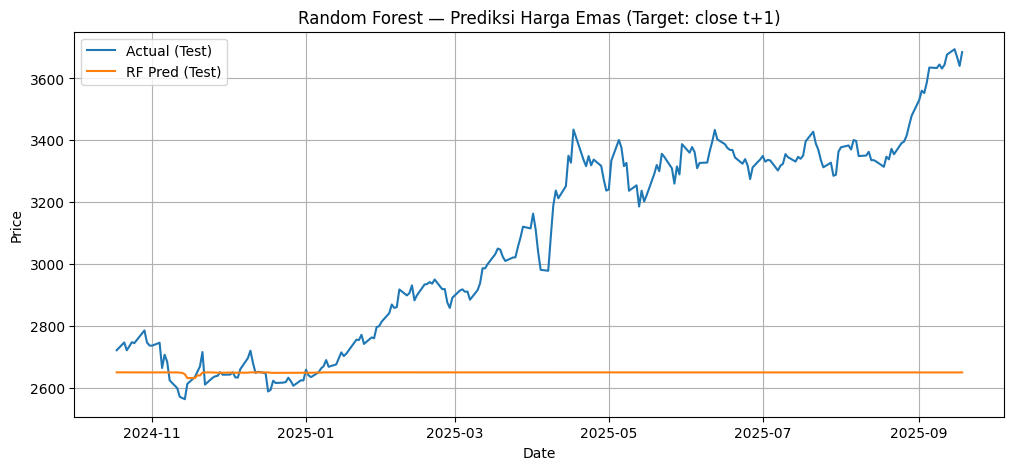

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest versi sederhana
rf_model_simple = RandomForestRegressor(
    n_estimators=100,     # jumlah pohon dikurangi
    max_depth=5,          # batasi kedalaman → cegah hafalan
    min_samples_split=20, # biar tiap split butuh cukup data
    min_samples_leaf=10,  # tiap daun minimal 10 data
    random_state=42,
    n_jobs=-1
)

# Latih model
rf_model_simple.fit(X_train, y_train)

# Prediksi
y_train_pred = rf_model_simple.predict(X_train)
y_test_pred = rf_model_simple.predict(X_test)

# Evaluasi
eval_model(y_train, y_train_pred, "Train (Simple RF)")
eval_model(y_test, y_test_pred, "Test (Simple RF)")

# ===== Plot hasil Test =====
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual (Test)") # Corrected: Use y_test.index for dates
plt.plot(y_test.index, y_test_pred, label="RF Pred (Test)") # Corrected: Use y_test.index for dates
plt.title("Random Forest — Prediksi Harga Emas (Target: close t+1)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True); plt.show()


Train -> MAE: 1.01 | RMSE: 1.31 | R²: 1.0000 | MAPE: 0.05%
Test -> MAE: 406.79 | RMSE: 509.86 | R²: -1.5228 | MAPE: 12.34%


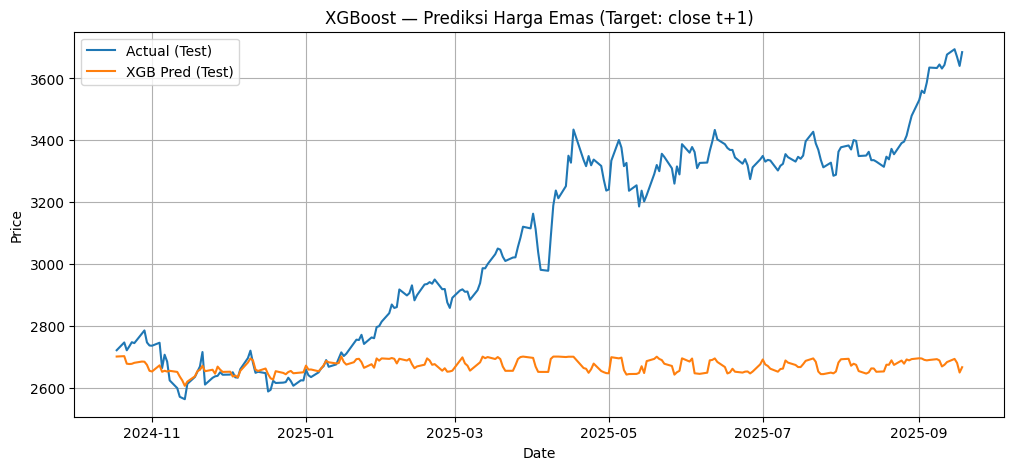

In [ ]:
#XGB
# === 0. Install (kalau di Colab) ===
# !pip install xgboost -q

from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# ===== Model XGBoost (versi cocok untuk Colab lama) =====
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
    n_jobs=-1,
    eval_metric="rmse"   # versi lama: taruh di sini
)

xgb.fit(X_train, y_train)   # tanpa early_stopping_rounds

# ===== Prediksi =====
y_train_pred = xgb.predict(X_train)
y_test_pred  = xgb.predict(X_test)

# ===== Evaluasi =====
def evaluate(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(((y_true - y_pred)**2).mean())
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} -> MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")

evaluate(y_train, y_train_pred, "Train")
evaluate(y_test,  y_test_pred,  "Test")

# ===== Plot hasil Test =====
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual (Test)") # Corrected: Use y_test.index for dates
plt.plot(y_test.index, y_test_pred, label="XGB Pred (Test)") # Corrected: Use y_test.index for dates
plt.title("XGBoost — Prediksi Harga Emas (Target: close t+1)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True); plt.show()


#NEWWW
Absolute hybrid ARIMAX vs Hybrid

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_model(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{name:25s} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")


In [ ]:
# df: punya kolom ['date','open','high','low','close','dxy', ...]
df = df.set_index('date').sort_index()

# 🎯 TARGET: harga close BESOK (level, bukan diff)
df['target'] = df['close'].shift(-1)

# contoh fitur yang dipakai (boleh tambahin lagi)
feature_cols = ['open', 'high', 'low', 'close', 'dxy']

# lag yang kamu pakai sebelumnya
lags = [1, 3, 7, 14]

for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# kalau kamu punya MA/STD dsb bisa ditambah di sini juga
# df['close_ma5'] = df['close'].rolling(5).mean()
# df['close_std5'] = df['close'].rolling(5).std()
# dst.

# buang baris yang kena shift/lag (NaN)
df = df.dropna()

# y = target, X_exog = semua fitur lag / MA / STD
y = df['target']

X_exog = df.drop(columns=[
    'target',
    'open', 'high', 'low', 'close', 'dxy'  # cuma pakai lag/MA/STD sebagai fitur
])

print("Shape X_exog:", X_exog.shape)


Shape X_exog: (1193, 20)


In [ ]:
split_idx = int(len(df) * 0.8)

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

X_train_exog = X_exog.iloc[:split_idx]
X_test_exog  = X_exog.iloc[split_idx:]

print(f"Train: {len(y_train)} baris, Test: {len(y_test)} baris")


Train: 954 baris, Test: 239 baris


In [ ]:
# Naive: prediksi target = harga close hari ini (kolom 'close' yang sudah align dengan y)
close_aligned = df['close']          # index sama dengan y

naive_train = close_aligned.iloc[:split_idx]
naive_test  = close_aligned.iloc[split_idx:]


In [ ]:
print("\nMelatih ARIMAX (1,1,1)...")

arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train_exog,
    order=(1, 1, 1),   # <<< beda dari sebelumnya (0,0,0)
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_result = arimax_model.fit(disp=False)

# prediksi in-sample & out-of-sample
y_pred_arimax_train = arimax_result.predict(
    start=0, # Use integer index
    end=len(y_train)-1, # Use integer index
    exog=X_train_exog
)

y_pred_arimax_test = arimax_result.predict(
    start=len(y_train), # Use integer index
    end=len(df)-1, # Use integer index
    exog=X_test_exog
)

print("ARIMAX selesai.")


Melatih ARIMAX (1,1,1)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMAX selesai.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# residual train = actual - prediksi ARIMAX
residuals_train = y_train - y_pred_arimax_train

print("\nMelatih XGBoost pada residual...")
xgb_model_resid = XGBRegressor(
    n_estimators=200,
    max_depth=3,
    min_child_weight=5,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

xgb_model_resid.fit(X_train_exog, residuals_train)
print("XGBoost residual selesai.")



Melatih XGBoost pada residual...
XGBoost residual selesai.


In [ ]:
print("\nMembuat prediksi final...")

# prediksi residual
resid_pred_train = xgb_model_resid.predict(X_train_exog)
resid_pred_test  = xgb_model_resid.predict(X_test_exog)

# hybrid = ARIMAX + XGB(residual)
final_pred_train = y_pred_arimax_train + resid_pred_train
final_pred_test  = y_pred_arimax_test + resid_pred_test

print("\n=== Evaluasi ===")
eval_model(y_train, naive_train,          "Naive (Train)")
eval_model(y_test,  naive_test,           "Naive (Test)")

print()
eval_model(y_train, y_pred_arimax_train,  "ARIMAX Only (Train)")
eval_model(y_test,  y_pred_arimax_test,   "ARIMAX Only (Test)")

print()
eval_model(y_train, final_pred_train,     "Hybrid ARIMAX+XGB (Train)")
eval_model(y_test,  final_pred_test,      "Hybrid ARIMAX+XGB (Test)")



Membuat prediksi final...

=== Evaluasi ===
Naive (Train)             -> MAE: 12.72, RMSE: 17.00, R²: 0.9947, MAPE: 0.65%
Naive (Test)              -> MAE: 25.58, RMSE: 33.95, R²: 0.9888, MAPE: 0.83%

ARIMAX Only (Train)       -> MAE: 15.01, RMSE: 59.45, R²: 0.9349, MAPE: 0.78%
ARIMAX Only (Test)        -> MAE: 355.16, RMSE: 440.07, R²: -0.8794, MAPE: nan%

Hybrid ARIMAX+XGB (Train) -> MAE: 6.17, RMSE: 8.08, R²: 0.9988, MAPE: 0.32%
Hybrid ARIMAX+XGB (Test)  -> MAE: 355.28, RMSE: 438.06, R²: -0.8622, MAPE: nan%


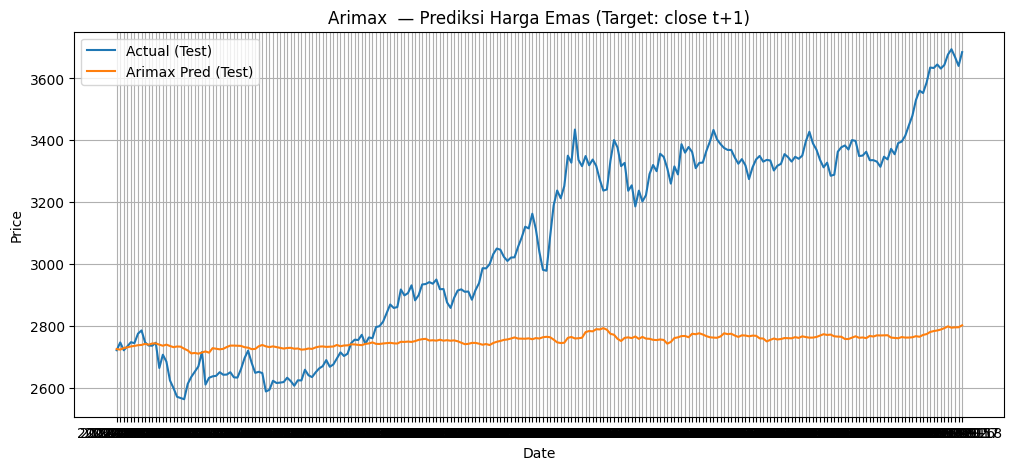

In [ ]:
# ===== Plot hasil Test =====
plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label="Actual (Test)") # Corrected: Use y_test.index for dates
plt.plot(y_test.index, y_pred_arimax_test, label="Arimax Pred (Test)") # Corrected: Use y_test.index for dates
plt.title("Arimax  — Prediksi Harga Emas (Target: close t+1)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True); plt.show()

#Skenario 2
Model RF vs XGB vs ARIMAX

###Return
w ma, std, dist from ma7 feature importance for rf only xgb no cuz lower result

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Asumsikan 'df' adalah DataFrame awal Anda yang sudah di-load

# ==== 1. Persiapan Data Terpusat (Best Practice) ====
df = df.set_index('date').sort_index()

# [TARGET DEFINITION] Target adalah PERUBAHAN HARGA besok
df['target'] = df['close'].diff().shift(-1)

# a. Fitur AR (Autoregresi) -> return dari hari-hari kemarin
# Ini adalah fitur "target" yang Anda maksud
lags_ar = [1, 2, 3, 7, 14] # Ini adalah close_diff_lag1, dst.
for lag in lags_ar:
    # return_lag1 = return hari ini (close_diff)
    # return_lag2 = return kemarin (close_diff.shift(1))
    df[f'return_lag{lag}'] = df['target'].shift(lag) # Perhatikan lag-1


# [LAG FEATURES] Buat fitur lag dari LEVEL HARGA ASLI, bukan dari diff
feature_cols = ['open', 'high', 'low','close', 'dxy']
lags = [1, 3, 7, 14]
for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag) # <--- Diperbaiki: tidak pakai .diff() di sini

# Drop NaN setelah semua fitur dibuat
df.dropna(inplace=True)

# === 3b. Buat Fitur "Pintar" (MA & STD) ===

# --- Fitur Tren (Moving Averages) ---
# Dihitung dari HARGA ('close'), tapi di-shift(1) agar tidak bocor
df['ma_7'] = df['close'].shift(1).rolling(window=7).mean()
df['ma_21'] = df['close'].shift(1).rolling(window=21).mean()

# --- Fitur Volatilitas (Rolling STD) ---
# Dihitung dari RETURN ('target'), di-shift(1) agar tidak bocor
df['vol_7'] = df['target'].shift(1).rolling(window=7).std()
df['vol_21'] = df['target'].shift(1).rolling(window=21).std()

# --- [OPSIONAL TAPI SANGAT DISARANKAN] Fitur Momentum ---
# Seberapa jauh harga kemarin dari tren-nya?
# Pastikan 'close_lag1' sudah ada, jika belum: df['close_lag1'] = df['close'].shift(1)
df['dist_from_ma_7'] = df['close_lag1'] - df['ma_7']

# Buang baris NaN yang tercipta dari rolling window
df = df.dropna()


# ==== 2. Definisikan Final X dan y (Anti-Leakage) == ==
# y adalah target perubahan harga
y = df['target']
# X HANYA berisi informasi masa lalu (kolom lag) untuk menghindari leakage
X = df.drop(columns=['target', 'open', 'high', 'low', 'close', 'dxy'])


# ==== 3. Split Data yang Sudah Bersih ====
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Simpan harga close ASLI untuk evaluasi akhir
y_train_actual_prices = df['close'].iloc[:split_idx]
y_test_actual_prices = df['close'].iloc[split_idx:]


In [ ]:
# # === 4. Model XGBoost (JAUH LEBIH SEDERHANA) ===
# xgb_model = XGBRegressor(
#     n_estimators=100,      # <-- KURANGI (lebih sedikit pohon)
#     max_depth=3,           # <-- KURANGI (pohon lebih dangkal, ini WAJIB)
#     learning_rate=0.05,    # <-- Boleh tetap

#     # Tambahkan parameter ini untuk "menenangkan" model
#     min_child_weight=5,    # <-- TAMBAHKAN (mencegah pohon belajar dari noise)

#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )

# === 4. Model XGBoost (JAUH LEBIH SEDERHANA) ===
xgb_model = XGBRegressor(
    # n_estimators=100,
    # max_depth=2,           # <-- TURUNKAN LAGI jadi 2
    # learning_rate=0.05,
    # min_child_weight=10,   # <-- NAIKKAN jadi 10 atau 20
    # gamma=0.5,             # <-- TAMBAHKAN 'gamma' (regularisasi kuat)
    # subsample=0.7,         # <-- Sedikit kurangi
    # colsample_bytree=0.7,  # <-- Sedikit kurangi
    # random_state=42,
    # n_jobs=-1
    n_estimators=50,       # <-- KURANGI
    max_depth=2,           # <-- WAJIB: Sangat dangkal
    learning_rate=0.01,    # <-- Belajar SANGAT lambat
    min_child_weight=30,   # <-- NAIKKAN LAGI (butuh 30 data)
    gamma=10,              # <-- Regularisasi SANGAT TINGGI
    subsample=0.6,
    colsample_bytree=0.6,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=10, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=30, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
import pandas as pd

# Dapatkan nama fitur setelah training
feature_names = X_train.columns
importances = xgb_model.feature_importances_

# Buat DataFrame untuk melihatnya
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

        Feature  Importance
4     open_lag4    0.086641
23        vol_4    0.071294
2     open_lag2    0.064018
17     dxy_lag1    0.059499
22        ma_12    0.059377
9      low_lag1    0.058559
14   close_lag2    0.056233
18     dxy_lag2    0.055527
11     low_lag3    0.053583
1     open_lag1    0.052523
20     dxy_lag4    0.052427
10     low_lag2    0.052386
0   return_lag1    0.048438
12     low_lag4    0.048433
3     open_lag3    0.043819
6     high_lag2    0.033303
8     high_lag4    0.033185
7     high_lag3    0.030145
16   close_lag4    0.022609
19     dxy_lag3    0.018001
5     high_lag1    0.000000
13   close_lag1    0.000000
15   close_lag3    0.000000
21         ma_4    0.000000


In [ ]:



# === 4. Model XGBoost (JAUH LEBIH SEDERHANA) ===
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=2,           # <-- TURUNKAN LAGI jadi 2
    learning_rate=0.05,
    min_child_weight=10,   # <-- NAIKKAN jadi 10 atau 20
    gamma=0.5,             # <-- TAMBAHKAN 'gamma' (regularisasi kuat)
    subsample=0.7,         # <-- Sedikit kurangi
    colsample_bytree=0.7,  # <-- Sedikit kurangi
    random_state=42,
    n_jobs=-1
)
# ==== 5. Train Model ====
# Pilih 10 fitur teratas
# top_15_features = importance_df['Feature'].head(15).tolist()

# # Buat ulang X_train dan X_test HANYA dengan fitur-fitur ini
# X_train_simple = X_train[top_15_features]
# X_test_simple = X_test[top_15_features]

# Latih model dengan fitur yang disederhanakan
xgb_model.fit(X_train, y_train)


# ==== 6. Prediksi, Konversi, dan Evaluasi ====
# Fungsi evaluasi
def eval_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

print("=== Evaluasi pada Prediksi Harga Absolut ===")

# --- Evaluasi pada Data Latih ---
# Gunakan X_train_simple untuk prediksi
y_train_pred_diffs = xgb_model.predict(X_train)
last_prices_train = X_train['close_lag1']
predicted_prices_train = last_prices_train + y_train_pred_diffs
eval_model(y_train_actual_prices, predicted_prices_train, "Train")

# --- Evaluasi pada Data Uji ---
# Gunakan X_test_simple untuk prediksi
y_test_pred_diffs = xgb_model.predict(X_test)
last_prices_test = X_test['close_lag1']
predicted_prices_test = last_prices_test + y_test_pred_diffs
eval_model(y_test_actual_prices, predicted_prices_test, "Test")

# === Evaluasi JUJUR pada Prediksi Return/Diff ===
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")

# Anda sudah punya variabel-variabel ini dari atas:
# y_train -> return asli
# y_test  -> return asli
# y_train_pred_diffs -> prediksi return dari model
# y_test_pred_diffs  -> prediksi return dari model

# Evaluasi performa model pada tugas SEBENARNYA (memprediksi return)
eval_model(y_train, y_train_pred_diffs, "Train Return")
eval_model(y_test, y_test_pred_diffs, "Test Return")

=== Evaluasi pada Prediksi Harga Absolut ===
Train -> MAE: 12.89, RMSE: 17.11, R²: 0.9948, MAPE: 0.65%
Test -> MAE: 26.37, RMSE: 34.47, R²: 0.9883, MAPE: 0.85%

=== Evaluasi JUJUR pada Prediksi Return/Diff ===
Train Return -> MAE: 11.80, RMSE: 15.59, R²: 0.1538, MAPE: 145.06%
Test Return -> MAE: 25.68, RMSE: 34.08, R²: -0.0098, MAPE: 155.15%


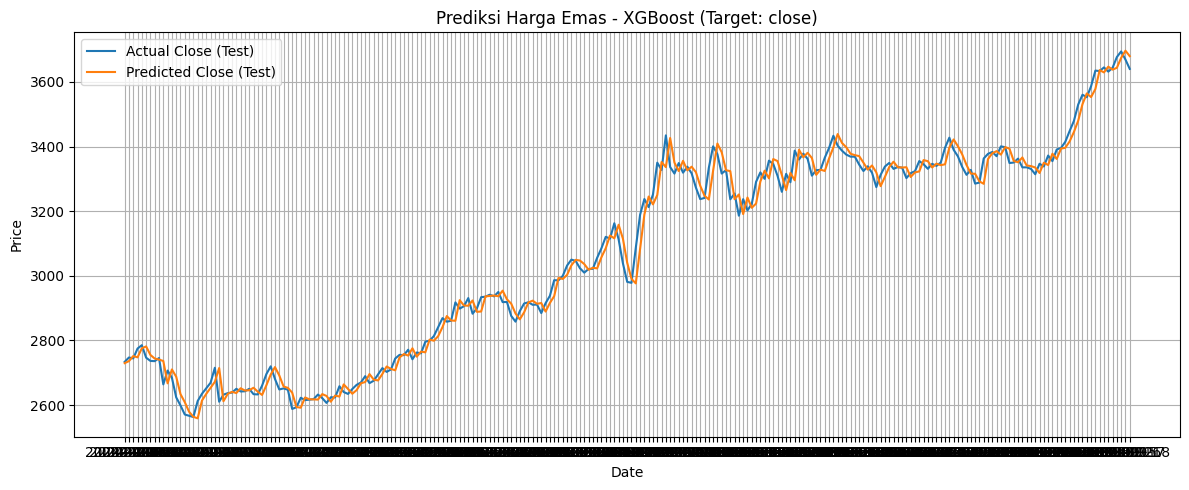

In [ ]:
import matplotlib.pyplot as plt

# Biar yakin index-nya sejajar
actual_test = y_test_actual_prices.copy()
pred_test   = pd.Series(predicted_prices_test, index=actual_test.index)

plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test, label="Actual Close (Test)")
plt.plot(actual_test.index, pred_test, label="Predicted Close (Test)")
plt.title("Prediksi Harga Emas - XGBoost (Target: close)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

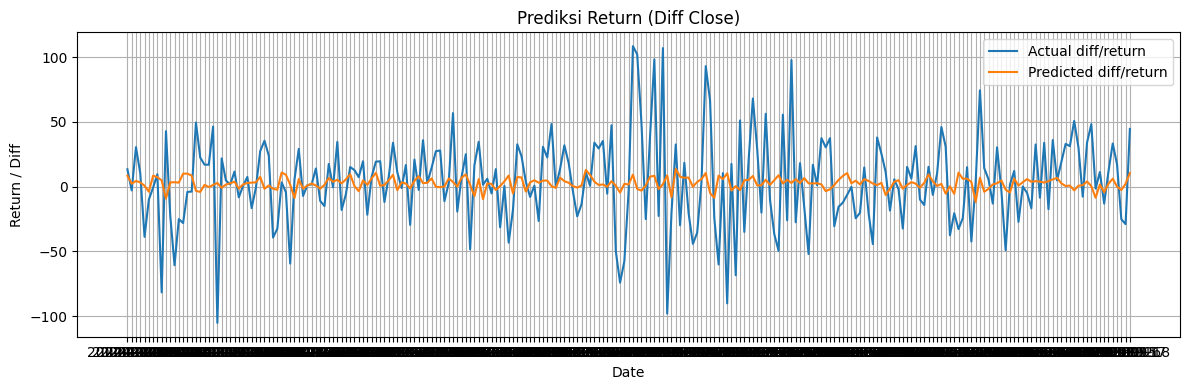

In [ ]:
# Return test: actual vs predicted diff
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test, label="Actual diff/return")
plt.plot(y_test.index, y_test_pred_diffs, label="Predicted diff/return")
plt.title("Prediksi Return (Diff Close)")
plt.xlabel("Date")
plt.ylabel("Return / Diff")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Asumsikan 'df' adalah DataFrame awal Anda yang sudah di-load

# ==== 1. Persiapan Data Terpusat (Best Practice) ====
df = df.set_index('date').sort_index()

# [TARGET DEFINITION] Target adalah PERUBAHAN HARGA besok
df['target'] = df['close'].diff().shift(-1)

# a. Fitur AR (Autoregresi) -> return dari hari-hari kemarin
# Ini adalah fitur "target" yang Anda maksud
lags_ar = [1, 2, 3 , 7, 14] # Ini adalah close_diff_lag1, dst.
for lag in lags_ar:
    # return_lag1 = return hari ini (close_diff)
    # return_lag2 = return kemarin (close_diff.shift(1))
    df[f'return_lag{lag}'] = df['target'].shift(lag) # Perhatikan lag-1

# [LAG FEATURES] Buat fitur lag dari semua kolom relevan
feature_cols = ['open', 'high', 'low', 'close', 'dxy']
lags = [1, 3, 7, 14]
for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Drop NaN setelah semua fitur dibuat
df.dropna(inplace=True)

# === 3b. Buat Fitur "Pintar" (MA & STD) ===

# --- Fitur Tren (Moving Averages) ---
# Dihitung dari HARGA ('close'), tapi di-shift(1) agar tidak bocor
df['ma_7'] = df['close'].shift(1).rolling(window=7).mean()
df['ma_21'] = df['close'].shift(1).rolling(window=21).mean()

# --- Fitur Volatilitas (Rolling STD) ---
# Dihitung dari RETURN ('target'), di-shift(1) agar tidak bocor
df['vol_7'] = df['target'].shift(1).rolling(window=7).std()
df['vol_21'] = df['target'].shift(1).rolling(window=21).std()

# --- [OPSIONAL TAPI SANGAT DISARANKAN] Fitur Momentum ---
# Seberapa jauh harga kemarin dari tren-nya?
# Pastikan 'close_lag1' sudah ada, jika belum: df['close_lag1'] = df['close'].shift(1)
df['dist_from_ma_7'] = df['close_lag1'] - df['ma_7']

# Buang baris NaN yang tercipta dari rolling window
df = df.dropna()


# ==== 2. Definisikan Final X dan y ====
# y adalah target perubahan harga
y = df['target']
# X HANYA berisi informasi masa lalu (kolom lag) untuk menghindari leakage
X = df.drop(columns=['target', 'open', 'high', 'low', 'close', 'dxy'])


# ==== 3. Split Data yang Sudah Bersih ====
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Simpan harga close ASLI untuk evaluasi akhir
y_train_actual_prices = df['close'].iloc[:split_idx]
y_test_actual_prices = df['close'].iloc[split_idx:]

In [ ]:
# # ==== 4. Model RF (Konservatif) ====
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=4,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

# ==== 5. Train Model ====
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_leaf=20, n_jobs=-1,
                      random_state=42)

In [ ]:
import pandas as pd

# Dapatkan nama fitur setelah training
feature_names = X_train.columns
importances = rf_model.feature_importances_

# Buat DataFrame untuk melihatnya
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

           Feature  Importance
1      return_lag2    0.151612
3      return_lag7    0.093838
29  dist_from_ma_7    0.083573
0      return_lag1    0.073289
4     return_lag14    0.066540
27           vol_7    0.063600
2      return_lag3    0.059058
23        dxy_lag7    0.039981
28          vol_21    0.038986
20     close_lag14    0.026354
8       open_lag14    0.025177
24       dxy_lag14    0.024082
21        dxy_lag1    0.023432
19      close_lag7    0.022961
22        dxy_lag3    0.022722
11       high_lag7    0.019319
25            ma_7    0.017406
6        open_lag3    0.016776
13        low_lag1    0.016070
12      high_lag14    0.014623
10       high_lag3    0.012473
9        high_lag1    0.012280
18      close_lag3    0.011172
17      close_lag1    0.011134
26           ma_21    0.011109
16       low_lag14    0.011067
7        open_lag7    0.010220
5        open_lag1    0.009053
15        low_lag7    0.006173
14        low_lag3    0.005918


In [ ]:


# ==== 5. Train Model ====
# Pilih 10 fitur teratas
top_15_features = importance_df['Feature'].head(15).tolist()

# Buat ulang X_train dan X_test HANYA dengan fitur-fitur ini
X_train_simple = X_train[top_15_features]
X_test_simple = X_test[top_15_features]

# Latih model dengan fitur yang disederhanakan
rf_model.fit(X_train_simple, y_train)

# ==== 6. Prediksi dan Evaluasi ====
# Fungsi evaluasi
def eval_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

print("=== Evaluasi pada Prediksi Harga Absolut ===")

# --- Evaluasi pada Data Latih ---
y_train_pred_diffs = rf_model.predict(X_train_simple)
last_prices_train = X_train['close_lag1']
predicted_prices_train = last_prices_train + y_train_pred_diffs
eval_model(y_train_actual_prices, predicted_prices_train, "Train")

# --- Evaluasi pada Data Uji ---
y_test_pred_diffs = rf_model.predict(X_test_simple)
last_prices_test = X_test['close_lag1']
predicted_prices_test = last_prices_test + y_test_pred_diffs
eval_model(y_test_actual_prices, predicted_prices_test, "Test")

# === Evaluasi JUJUR pada Prediksi Return/Diff ===
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")

# Anda sudah punya variabel-variabel ini dari atas:
# y_train -> return asli
# y_test  -> return asli
# y_train_pred_diffs -> prediksi return dari model
# y_test_pred_diffs  -> prediksi return dari model

# Evaluasi performa model pada tugas SEBENARNYA (memprediksi return)
eval_model(y_train, y_train_pred_diffs, "Train Return")
eval_model(y_test, y_test_pred_diffs, "Test Return")

=== Evaluasi pada Prediksi Harga Absolut ===
Train -> MAE: 12.78, RMSE: 17.01, R²: 0.9949, MAPE: 0.65%
Test -> MAE: 25.74, RMSE: 34.19, R²: 0.9885, MAPE: 0.83%

=== Evaluasi JUJUR pada Prediksi Return/Diff ===
Train Return -> MAE: 11.96, RMSE: 15.93, R²: 0.1165, MAPE: 131.47%
Test Return -> MAE: 25.68, RMSE: 34.03, R²: -0.0068, MAPE: 146.94%


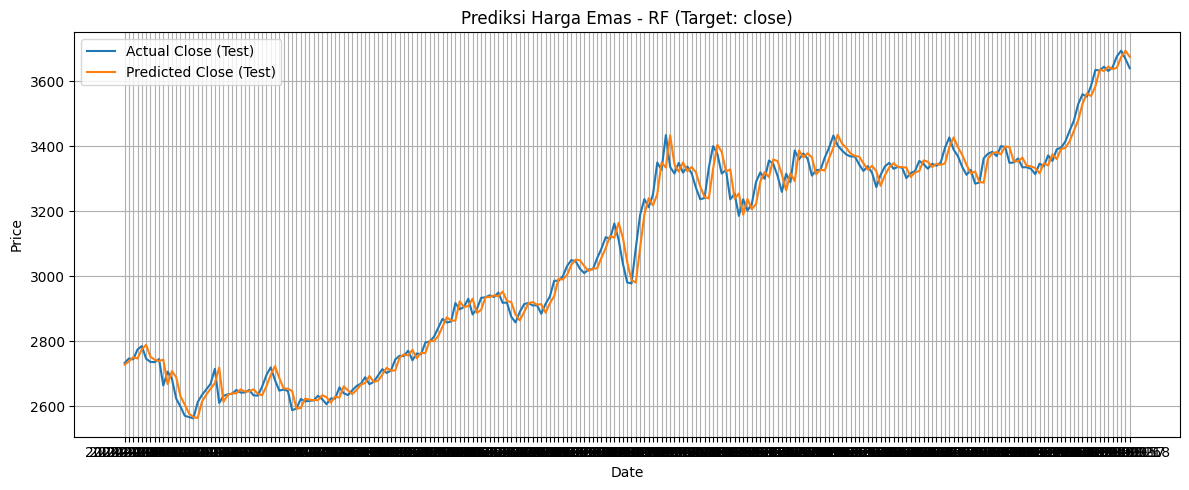

In [ ]:
import matplotlib.pyplot as plt

# Biar yakin index-nya sejajar
actual_test = y_test_actual_prices.copy()
pred_test   = pd.Series(predicted_prices_test, index=actual_test.index)

plt.figure(figsize=(12, 5))
plt.plot(actual_test.index, actual_test, label="Actual Close (Test)")
plt.plot(actual_test.index, pred_test, label="Predicted Close (Test)")
plt.title("Prediksi Harga Emas - RF (Target: close)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

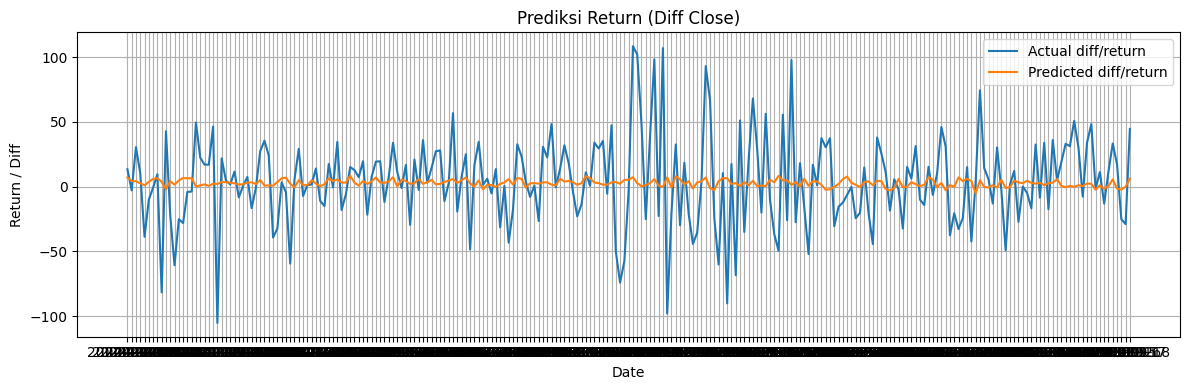

In [ ]:
# Return test: actual vs predicted diff
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test, label="Actual diff/return")
plt.plot(y_test.index, y_test_pred_diffs, label="Predicted diff/return")
plt.title("Prediksi Return (Diff Close)")
plt.xlabel("Date")
plt.ylabel("Return / Diff")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Lanjutan return

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations']
    print(f'ADF Test: {title}')
    for value, label in zip(result[0:4], labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("✅ Data stasioner (tolak H0)")
    else:
        print("❌ Data tidak stasioner (gagal tolak H0)")
    print('----------------------------------')

adf_test(df["close"], "Harga Emas")
adf_test(df["dxy"], "Indeks DXY")


ADF Test: Harga Emas
ADF Statistic : 1.9621592965968235
p-value : 0.9986217166906971
# Lags Used : 0
Number of Observations : 1192
❌ Data tidak stasioner (gagal tolak H0)
----------------------------------
ADF Test: Indeks DXY
ADF Statistic : -2.109072264370297
p-value : 0.24088228155028335
# Lags Used : 0
Number of Observations : 1192
❌ Data tidak stasioner (gagal tolak H0)
----------------------------------


In [ ]:
from statsmodels.tsa.stattools import adfuller

def find_optimal_d(series, max_d=3):
    for d in range(max_d+1):
        test_series = series.diff(d).dropna() if d > 0 else series
        p_value = adfuller(test_series)[1]
        print(f"d={d}, p-value={p_value:.4f}")
        if p_value <= 0.05:
            print(f"✅ Data stasioner pada d={d}")
            return d
    print("❌ Data belum stasioner hingga d maksimum.")
    return max_d

d_optimal = find_optimal_d(df["target"])


d=0, p-value=0.9988
d=1, p-value=0.0000
✅ Data stasioner pada d=1


In [ ]:
# Differencing d kali
df["close_diff"] = df["close"].diff(d_optimal)
# df["dxy_diff"] = df["dxy"].diff()

# Drop baris pertama yang jadi NaN
df = df.dropna().reset_index(drop=True)

# Uji ulang ADF untuk memastikan sudah stasioner
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Test: {title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("✅ Data sudah stasioner")
    else:
        print("❌ Data belum stasioner")
    print('----------------------------------')

adf_test(df["close_diff"], "Harga Emas (Differencing)")
adf_test(df["close"], "Harga Emas")
# adf_test(df["dxy_diff"], "Indeks DXY (Differencing)")

ADF Test: Harga Emas (Differencing)
ADF Statistic: -34.3499
p-value: 0.0000
✅ Data sudah stasioner
----------------------------------
ADF Test: Harga Emas
ADF Statistic: 1.9618
p-value: 0.9986
❌ Data belum stasioner
----------------------------------


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(df["close_diff"].dropna(), lags=30, ax=plt.gca())
plt.title("ACF Harga Emas")

plt.subplot(1,2,2)
plot_pacf(df["close_diff"].dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF Harga Emas")
plt.show()


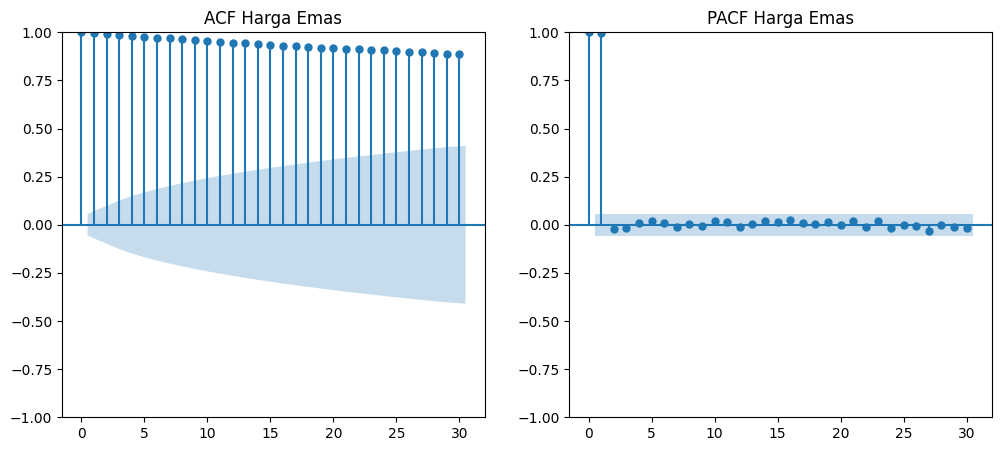

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_acf(df["close"].dropna(), lags=30, ax=plt.gca())
plt.title("ACF Harga Emas")

plt.subplot(1,2,2)
plot_pacf(df["close"].dropna(), lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF Harga Emas")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# =========================================
# 0. LOAD & SORT DATA
# =========================================
# Asumsikan 'df' adalah DataFrame mentah Anda (o, h, l, c, dxy)
# df = pd.read_csv(...)  # contoh

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")

# =========================================
# 1. TARGET & LAG DASAR
# =========================================
# Target model: perubahan harga (diff)
df['close_diff'] = df['close'].diff()

# Fitur lag dari LEVEL harga asli (bukan diff)
feature_cols = ['open', 'high', 'low', 'close', 'dxy']
lags = [1, 3, 7, 14]
for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Shortcut khusus untuk close lag 1 (buat rekonstruksi harga)
df['close_lag1'] = df['close'].shift(1)

# Drop NaN dari diff + lag
df.dropna(inplace=True)

# =========================================
# 2. FITUR MA, VOL, MOMENTUM
# =========================================

# --- Moving Average dari harga close (di-shift biar gak bocor) ---
df['ma_7'] = df['close'].shift(1).rolling(window=7).mean()
df['ma_21'] = df['close'].shift(1).rolling(window=21).mean()

# --- Volatilitas dari diff (close_diff) ---
df['vol_7'] = df['close_diff'].shift(1).rolling(window=7).std()
df['vol_21'] = df['close_diff'].shift(1).rolling(window=21).std()

# --- Momentum: jarak harga kemarin ke MA-nya ---
df['dist_from_ma_7'] = df['close_lag1'] - df['ma_7']

# Buang NaN dari rolling window
df = df.dropna()

# =========================================
# 3. TRAIN / TEST SPLIT
# =========================================
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx].copy()
test = df.iloc[split_idx:].copy()

# Target untuk model (diff)
y_train = train["close_diff"]
y_test = test["close_diff"]   # <-- tadi ini belum ada

# =========================================
# 4. EXOGENOUS FEATURES (ANTI-LEAK)
# =========================================
# Buang kolom yang:
# - bukan fitur (date, harga asli, target, dll)
# - atau raw OHLC+DXY yang sudah kita represent lewat lag/MA/vol
drop_cols = [
    'date',        # datetime, jangan masuk exog
    'close_diff',  # target
    'open', 'high', 'low', 'close', 'dxy'  # level harga mentah
]

X_train_exog = train.drop(columns=drop_cols)
X_test_exog = test.drop(columns=drop_cols)

# =========================================
# 5. VARIABEL UNTUK EVALUASI
# =========================================
# Harga aktual (daily close)
y_train_actual_prices = train["close"]
y_test_actual_prices = test["close"]

# Harga kemarin (untuk rekonstruksi dari diff -> price)
last_prices_train = train["close_lag1"]
last_prices_test = test["close_lag1"]

# =========================================
# 6. BANGUN MODEL ARIMAX
# =========================================
# d=0 karena kita sudah diff manual di 'close_diff'
model = SARIMAX(
    endog=y_train,
    exog=X_train_exog,
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

result = model.fit(disp=False)

# =========================================
# 7. PREDIKSI DIFF (RETURN) & REKONSTRUKSI HARGA
# =========================================
# In-sample (train)
y_train_pred_diffs = result.predict(
    start=0,
    end=len(y_train) - 1,
    exog=X_train_exog
)

# Out-of-sample (test)
y_test_pred_diffs = result.forecast(
    steps=len(test),
    exog=X_test_exog
)

# =========================================
# 8. FUNGSI EVALUASI
# =========================================
def eval_model(y_true, y_pred, dataset_name=""):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    print(f"{dataset_name} -> "
          f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, "
          f"R²: {r2:.4f}, MAPE: {mape:.2f}%")

# =========================================
# 9. EVALUASI DALAM SATUAN HARGA (REKONSTRUKSI)
# =========================================
predicted_prices_train = np.array(last_prices_train) + np.array(y_train_pred_diffs)
predicted_prices_test = np.array(last_prices_test) + np.array(y_test_pred_diffs)

eval_model(y_train_actual_prices, predicted_prices_train, "Train Price")
eval_model(y_test_actual_prices, predicted_prices_test, "Test Price")

# =========================================
# 10. EVALUASI JUJUR DI DOMAIN DIFF (RETURN)
# =========================================
print("\n=== Evaluasi JUJUR di domain diff (return) ===")
eval_model(y_train, y_train_pred_diffs, "Train Diff")
eval_model(y_test, y_test_pred_diffs, "Test Diff")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Train Price -> MAE: 12.52, RMSE: 16.63, R²: 0.9951, MAPE: 0.64%
Test Price -> MAE: 26.18, RMSE: 34.51, R²: 0.9884, MAPE: 0.85%

=== Evaluasi JUJUR di domain diff (return) ===
Train Diff -> MAE: 12.52, RMSE: 16.63, R²: 0.0363, MAPE: 170.33%
Test Diff -> MAE: 26.18, RMSE: 34.51, R²: -0.0355, MAPE: 187.90%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Hybrid residual but return price

In [ ]:
#Ensemble + lag,MA,STD, konfig 1 0 1 liat xtrainexog
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================================
# ## 0. Fungsi Evaluasi JUJUR (dari kode Anda)
# ==========================================================
def eval_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# ==========================================================
# ## 1. Asumsi Data & Pemisahan X-y
# ==========================================================
# (Saya asumsikan 'df' Anda sudah siap dan NaN sudah di-drop)
#lag w shift
# Asumsikan 'df' adalah DataFrame awal Anda dengan kolom:
# 'date', 'open', 'high', 'low', 'close', 'dxy'
# Pastikan 'date' adalah index dan terurut
df = df.set_index('date').sort_index()

# LANGKAH 1: Buat Target Prediksi (Harga Close BESOK)
# Ini adalah langkah paling krusial. Kita geser kolom target ke atas.
df['target'] = df['close'].diff().shift(-1)

# LANGKAH 2: Buat Fitur HANYA dari Data Masa Lalu (Lag)
# Kita buat fitur lag dari semua kolom yang relevan
feature_cols = ['open', 'high', 'low', 'close', 'dxy']
for col in feature_cols:
    for lag in [1, 3, 7, 14]: # Anda bisa sesuaikan nilai lag
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# LANGKAH 3: Hapus Baris dengan Nilai Kosong (NaN)
# Ini akan menghapus beberapa baris di awal (karena lag) dan baris terakhir (karena target)
df.dropna(inplace=True)

# y adalah target (return/diff)
y = df['target']

# X_exog adalah SEMUA fitur (lag, MA, STD, dll)
# (Ini adalah X yang sama yang Anda gunakan untuk model ML murni)
X_exog = df.drop(columns=['target', 'open', 'high', 'low', 'close', 'dxy'])

# ==========================================================
# ## 2. Split Data (Train & Test)
# ==========================================================
split_idx = int(len(df) * 0.8)

# Split y
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Split X_exog (Fitur untuk ARIMAX dan XGB)
X_train_exog = X_exog.iloc[:split_idx]
X_test_exog = X_exog.iloc[split_idx:]

print(f"Data latih: {len(y_train)} baris, Data uji: {len(y_test)} baris")

# ==========================================================
# ## 3. [LANGKAH 1] Latih Model ARIMAX (Model Linier)
# ==========================================================
print("\nMelatih Model ARIMAX...")
# (Gunakan order Anda, d=0 karena y sudah di-diff)
arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train_exog,
    order=(0, 0, 0) # Contoh order, sesuaikan
)
arimax_result = arimax_model.fit(disp=False)
print("Model ARIMAX selesai dilatih.")

# ==========================================================
# ## 4. [LANGKAH 2] Dapatkan Residual dari Data Latih
# ==========================================================
# Dapatkan prediksi ARIMAX pada data latih (in-sample)
y_pred_arimax_train = arimax_result.predict(
    start=0,
    end=len(y_train)-1,
    exog=X_train_exog
)

# Hitung residual (error) -> ini akan jadi target baru untuk XGBoost
residuals_train = y_train - y_pred_arimax_train
print("Residual untuk data latih berhasil dihitung.")

# ==========================================================
# ## 5. [LANGKAH 3] Latih XGBoost pada Residual (Model Non-Linier)
# ==========================================================
print("\nMelatih Model XGBoost pada Residual...")
# Latih XGBoost untuk memprediksi 'residual'
# (Gunakan parameter "bodoh" Anda yang sudah di-tuning)
xgb_model_resid = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    min_child_weight=10,
    gamma=5,
    random_state=42,
    n_jobs=-1
)

# X adalah fitur exog, Y adalah RESIDUAL ARIMAX
xgb_model_resid.fit(X_train_exog, residuals_train)
print("Model XGBoost selesai dilatih.")

# ==========================================================
# ## 6. [LANGKAH 4] Buat Prediksi Final pada Data Uji
# ==========================================================
print("\nMembuat prediksi final pada data uji...")

# --- Prediksi ARIMAX (Bagian Linier) ---
y_pred_arimax_test = arimax_result.forecast(
    steps=len(y_test),
    exog=X_test_exog
)
# (Kita sudah punya y_pred_arimax_train dari LANGKAH 4)
y_pred_xgb_resid_train = xgb_model_resid.predict(X_train_exog)
# --- Prediksi XGBoost (Bagian Non-Linier/Residual) ---
# Minta XGBoost memprediksi 'sisa' error untuk data uji
y_pred_xgb_resid_test = xgb_model_resid.predict(X_test_exog)

# --- Gabungkan Keduanya ---
final_prediction_train = y_pred_arimax_train + y_pred_xgb_resid_train
final_prediction = y_pred_arimax_test + y_pred_xgb_resid_test

# ==========================================================
# ## 7. [LANGKAH 5] Evaluasi JUJUR
# ==========================================================
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")

# --- Evaluasi Model Hybrid ---
print("--- Model Ensemble (ARIMAX + XGB) ---")
eval_model(y_train, final_prediction_train, "Train Return Ensemble") # <-- BARU DITAMBAHKAN
eval_model(y_test, final_prediction, "Test Return Ensemble")

# --- Sebagai pembanding, evaluasi ARIMAX saja ---
print("\n--- Model ARIMAX Saja ---")
eval_model(y_train, y_pred_arimax_train, "Train Return ARIMAX Only")
eval_model(y_test, y_pred_arimax_test, "Test Return ARIMAX Only")

# --- Sebagai pembanding, evaluasi XGBoost saja (jika Anda sudah punya) ---
# (Ini adalah model XGB Anda yang overfitting dari sebelumnya)
# y_pred_xgb_only = ...
# print("\n--- Model XGBoost Saja (dari percobaan lama) ---")
# eval_model(y_test, y_pred_xgb_only, "Test Return XGB Only")

Data latih: 954 baris, Data uji: 239 baris

Melatih Model ARIMAX...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ARIMAX selesai dilatih.
Residual untuk data latih berhasil dihitung.

Melatih Model XGBoost pada Residual...
Model XGBoost selesai dilatih.

Membuat prediksi final pada data uji...

=== Evaluasi JUJUR pada Prediksi Return/Diff ===
--- Model Ensemble (ARIMAX + XGB) ---
Train Return Ensemble -> MAE: 7.86, RMSE: 10.14, R²: 0.6430, MAPE: 156.98%
Test Return Ensemble -> MAE: 26.48, RMSE: 35.00, R²: -0.0779, MAPE: nan%

--- Model ARIMAX Saja ---
Train Return ARIMAX Only -> MAE: 12.69, RMSE: 16.95, R²: 0.0032, MAPE: 168.73%
Test Return ARIMAX Only -> MAE: 25.54, RMSE: 34.00, R²: -0.0172, MAPE: nan%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/tmp/ipython-input-4089418245.py:15: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
/tmp/ipython-input-4089418245.py:15: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100


#EXTRAS
Model RF vs XGB vs ARIMAX

Mingguan but resample, L bruh

---



In [ ]:
import pandas as pd
import numpy as np

# ASUMSI: df adalah DataFrame HARIAN Anda
# Pastikan 'date' adalah index datetime
df = df.set_index('date').sort_index()

# Tentukan cara agregasi untuk tiap kolom
agg_dict = {
    'open': 'first',  # Ambil harga Open hari Senin
    'high': 'max',    # Ambil harga Tertinggi selama seminggu
    'low': 'min',     # Ambil harga Terendah selama seminggu
    'close': 'last',  # Ambil harga Close hari Jumat
    'dxy': 'mean',    # Ambil rata-rata DXY selama seminggu
    # (Tambahkan kolom lain jika ada)
}

# 'W' = Mingguan (berakhir hari Minggu). 'W-FRI' juga bisa (berakhir Jumat)
df_weekly = df.resample('W').agg(agg_dict)

# Hapus minggu-minggu di mana data tidak lengkap (misal: libur)
df_weekly.dropna(inplace=True)

print("Data harian berhasil diubah ke mingguan:")
print(df_weekly.head())

Data harian berhasil diubah ke mingguan:
               open      high      low     close        dxy
date                                                       
2020-09-27  1869.16  1875.220  1852.40  1861.740  117.87860
2020-10-04  1862.33  1917.190  1848.56  1899.300  117.12004
2020-10-11  1902.95  1921.000  1872.98  1884.600  116.24880
2021-02-14  1830.53  1855.420  1810.67  1824.255  111.69108
2021-02-21  1821.13  1827.185  1760.67  1783.980  111.84324


In [ ]:
# === 1. Buat Target (Y) MINGGUAN ===
# Ini adalah return/diff MINGGUAN
df_weekly['target'] = df_weekly['close'].diff()

# === 2. Buat Fitur (X) MINGGUAN (ANTI-LEAKAGE) ===

# --- Fitur Lag (1 minggu lalu, 2 minggu lalu) ---
# df_weekly['close_lag1'] = df_weekly['close'].shift(1)
df_weekly['return_lag1'] = df_weekly['target'].shift(1)
# df_weekly['vix_lag1'] = df_weekly['vix'].shift(1)

# --- Fitur Lag (dari O,H,L,C dan DXY) ---
# Ini adalah fitur yang Anda tanyakan:
feature_cols = ['open', 'high', 'low', 'close', 'dxy']
lags = [1, 2, 3, 4] # Ini adalah lag 1, 2, 3, 4 MINGGU

for col in feature_cols:
    for lag in lags:
        df_weekly[f'{col}_lag{lag}'] = df_weekly[col].shift(lag)
# (Tambahkan lag lain jika perlu)

# --- Fitur MA (Moving Averages MINGGUAN) ---
# MA 4-minggu (tren 1 bulan), MA 12-minggu (tren 3 bulan)
df_weekly['ma_4'] = df_weekly['close'].shift(1).rolling(window=4).mean()
df_weekly['ma_12'] = df_weekly['close'].shift(1).rolling(window=12).mean()

# --- Fitur Volatilitas MINGGUAN ---
df_weekly['vol_4'] = df_weekly['target'].shift(1).rolling(window=4).std()

# === 3. Bersihkan dan Definisikan X & Y Final ===
df_weekly.dropna(inplace=True)

y = df_weekly['target']

# X berisi SEMUA fitur lag/MA/vol MINGGUAN Anda
X = df_weekly.drop(columns=[
    'target', 'open', 'high', 'low', 'close',
    'dxy' # Hapus kolom mentah (non-lagged)
])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# (Kode split data Anda)
split_idx = int(len(df_weekly) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Simpan harga close ASLI untuk evaluasi akhir
# Corrected: Use df_weekly for actual prices to match the weekly predictions
y_train_actual_prices = df_weekly['close'].iloc[:split_idx]
y_test_actual_prices = df_weekly['close'].iloc[split_idx:]

# (Kode model XGB/RF Anda)
# (Tetap pakai parameter "bodoh" seperti max_depth=3)
# # ==== 4. Model RF (Konservatif) ====
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

# ==== 5. Train Model ====
rf_model.fit(X_train, y_train)



# ==== 6. Prediksi dan Evaluasi ====
# Fungsi evaluasi
def eval_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

print("=== Evaluasi pada Prediksi Harga Absolut ===")

# --- Evaluasi pada Data Latih ---
y_train_pred_diffs = rf_model.predict(X_train)
last_prices_train = X_train['close_lag1']
predicted_prices_train = last_prices_train + y_train_pred_diffs
eval_model(y_train_actual_prices, predicted_prices_train, "Train")

# --- Evaluasi pada Data Uji ---
y_test_pred_diffs = rf_model.predict(X_test)
last_prices_test = X_test['close_lag1']
predicted_prices_test = last_prices_test + y_test_pred_diffs
eval_model(y_test_actual_prices, predicted_prices_test, "Test")

# === Evaluasi JUJUR pada Prediksi Return/Diff ===
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")

# Anda sudah punya variabel-variabel ini dari atas:
# y_train -> return asli
# y_test  -> return asli
# y_train_pred_diffs -> prediksi return dari model
# y_test_pred_diffs  -> prediksi return dari model

# Evaluasi performa model pada tugas SEBENARNYA (memprediksi return)
eval_model(y_train, y_train_pred_diffs, "Train Return")
eval_model(y_test, y_test_pred_diffs, "Test Return")

=== Evaluasi pada Prediksi Harga Absolut ===
Train -> MAE: 25.99, RMSE: 33.76, R²: 0.9806, MAPE: 1.32%
Test -> MAE: 57.31, RMSE: 72.08, R²: 0.9499, MAPE: 1.85%

=== Evaluasi JUJUR pada Prediksi Return/Diff ===
Train Return -> MAE: 25.99, RMSE: 33.76, R²: 0.1558, MAPE: 151.06%
Test Return -> MAE: 57.31, RMSE: 72.08, R²: -0.0167, MAPE: 129.13%


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# (Kode split data Anda)
split_idx = int(len(df_weekly) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Simpan harga close ASLI untuk evaluasi akhir
# Corrected: Use df_weekly for actual prices to match the weekly predictions
y_train_actual_prices = df_weekly['close'].iloc[:split_idx]
y_test_actual_prices = df_weekly['close'].iloc[split_idx:]

# (Kode model XGB/RF Anda)
# (Tetap pakai parameter "bodoh" seperti max_depth=3)
# === 4. Model XGBoost (JAUH LEBIH SEDERHANA) ===
xgb_model = XGBRegressor(
    n_estimators=50,       # <-- KURANGI
    max_depth=2,           # <-- WAJIB: Sangat dangkal
    learning_rate=0.01,    # <-- Belajar SANGAT lambat
    min_child_weight=30,   # <-- NAIKKAN LAGI (butuh 30 data)
    gamma=10,              # <-- Regularisasi SANGAT TINGGI
    subsample=0.6,
    colsample_bytree=0.6,
    random_state=42
)

xgb_model.fit(X_train_simple, y_train)

# Pilih 10 fitur teratas
top_15_features = importance_df['Feature'].head(10).tolist()

# Buat ulang X_train dan X_test HANYA dengan fitur-fitur ini
X_train_simple = X_train[top_15_features]
X_test_simple = X_test[top_15_features]

# Latih model dengan fitur yang disederhanakan
xgb_model.fit(X_train_simple, y_train)

# ==== 6. Prediksi dan Evaluasi ====
# Fungsi evaluasi
def eval_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

print("=== Evaluasi pada Prediksi Harga Absolut ===")

# --- Evaluasi pada Data Latih ---
y_train_pred_diffs =xgb_model.predict(X_train_simple)
last_prices_train = X_train['close_lag1']
predicted_prices_train = last_prices_train + y_train_pred_diffs
eval_model(y_train_actual_prices, predicted_prices_train, "Train")

# --- Evaluasi pada Data Uji ---
y_test_pred_diffs = xgb_model.predict(X_test_simple)
last_prices_test = X_test['close_lag1']
predicted_prices_test = last_prices_test + y_test_pred_diffs
eval_model(y_test_actual_prices, predicted_prices_test, "Test")

# === Evaluasi JUJUR pada Prediksi Return/Diff ===
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")

# Anda sudah punya variabel-variabel ini dari atas:
# y_train -> return asli
# y_test  -> return asli
# y_train_pred_diffs -> prediksi return dari model
# y_test_pred_diffs  -> prediksi return dari model

# Evaluasi performa model pada tugas SEBENARNYA (memprediksi return)
eval_model(y_train, y_train_pred_diffs, "Train Return")
eval_model(y_test, y_test_pred_diffs, "Test Return")

=== Evaluasi pada Prediksi Harga Absolut ===
Train -> MAE: 27.34, RMSE: 35.81, R²: 0.9782, MAPE: 1.39%
Test -> MAE: 57.98, RMSE: 72.45, R²: 0.9494, MAPE: 1.87%

=== Evaluasi JUJUR pada Prediksi Return/Diff ===
Train Return -> MAE: 27.34, RMSE: 35.81, R²: 0.0502, MAPE: 122.61%
Test Return -> MAE: 57.98, RMSE: 72.45, R²: -0.0271, MAPE: 118.35%


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
import numpy as np # Pastikan numpy di-import

# (Asumsi df_weekly Anda sudah siap dengan SEMUA fitur: lag, ma, vol, dll)
# (dan df_weekly sudah di-dropna)

# ==== 2. Split Data (Train & Test) ====
split_idx = int(len(df_weekly) * 0.8)
train = df_weekly.iloc[:split_idx].copy()
test = df_weekly.iloc[split_idx:].copy()

# ==== 3. Definisikan Variabel untuk MODEL (ARIMAX) ====
y_train = train["target"]
y_test = test["target"] # <--- PERBAIKAN 1: Definisikan y_test

# --- PERBAIKAN 2: Definisi X_exog yang BENAR ---
# Kolom mentah yang harus dibuang dari frame fitur
# (Sesuaikan daftar ini jika Anda menambahkan VIX, F&G, dll.)
raw_cols_to_drop = ['target', 'open', 'high', 'low', 'close', 'dxy']

# X_exog sekarang akan berisi SEMUA fitur (lag, ma, vol, dist_from_ma, dll)
# BUKAN hanya fitur '_lag'
X_train_exog = train.drop(columns=raw_cols_to_drop, errors='ignore')
X_test_exog = test.drop(columns=raw_cols_to_drop, errors='ignore')

# ==== 4. Definisikan Variabel untuk EVALUASI ====
# (Kode Anda di sini sudah benar)
y_train_actual_prices = train["close"]
y_test_actual_prices = test["close"]
last_prices_train = train["close_lag1"]
last_prices_test = test["close_lag1"]

# ==== 5. Pembuatan Model ARIMAX ====
# d=0 karena y_train SUDAH di-diff secara manual
model = SARIMAX(
    endog=y_train,
    exog=X_train_exog,
    order=(1, 0, 1), # d=0 adalah KUNCI-nya
    enforce_stationarity=False,
    enforce_invertibility=False
)
result = model.fit(disp=False)

# ==== 6. Prediksi (Menghasilkan prediksi 'diff') ====
# Prediksi pada data latih (in-sample)
y_train_pred_diffs = result.predict(start=0, end=len(y_train)-1, exog=X_train_exog)
# Prediksi pada data uji (out-of-sample)
y_test_pred_diffs = result.forecast(steps=len(test), exog=X_test_exog)


# ==== 7. Evaluasi (Logika yang Anda Minta) ====

def eval_model(y_true, y_pred, dataset_name=""):
    # Ubah ke array NumPy untuk menghindari error indek s
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    # Tambahkan pencegahan untuk y_true yang bernilai 0
    y_true_safe = np.where(y_true == 0, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# --- Evaluasi pada Prediksi Harga Absolut ---
# (Saya memindahkan evaluasi Absolut ke atas agar konsisten)
print("\n=== Evaluasi pada Prediksi Harga Absolut ===")
predicted_prices_train = np.array(last_prices_train) + np.array(y_train_pred_diffs)
eval_model(y_train_actual_prices, predicted_prices_train, "Train")

predicted_prices_test = np.array(last_prices_test) + np.array(y_test_pred_diffs)
eval_model(y_test_actual_prices, predicted_prices_test, "Test")

# === Evaluasi JUJUR pada Prediksi Return/Diff ===
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")

# Evaluasi performa model pada tugas SEBENARNYA (memprediksi return)
eval_model(y_train, y_train_pred_diffs, "Train Return")
eval_model(y_test, y_test_pred_diffs, "Test Return") # <--- Kode ini sekarang akan berfungsi

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)



=== Evaluasi pada Prediksi Harga Absolut ===
Train -> MAE: 25.99, RMSE: 34.24, R²: 0.9801, MAPE: 1.33%
Test -> MAE: 62.51, RMSE: 84.66, R²: 0.9309, MAPE: 2.03%

=== Evaluasi JUJUR pada Prediksi Return/Diff ===
Train Return -> MAE: 25.99, RMSE: 34.24, R²: 0.1318, MAPE: 146.06%
Test Return -> MAE: 62.51, RMSE: 84.66, R²: -0.4023, MAPE: 136.72%




---



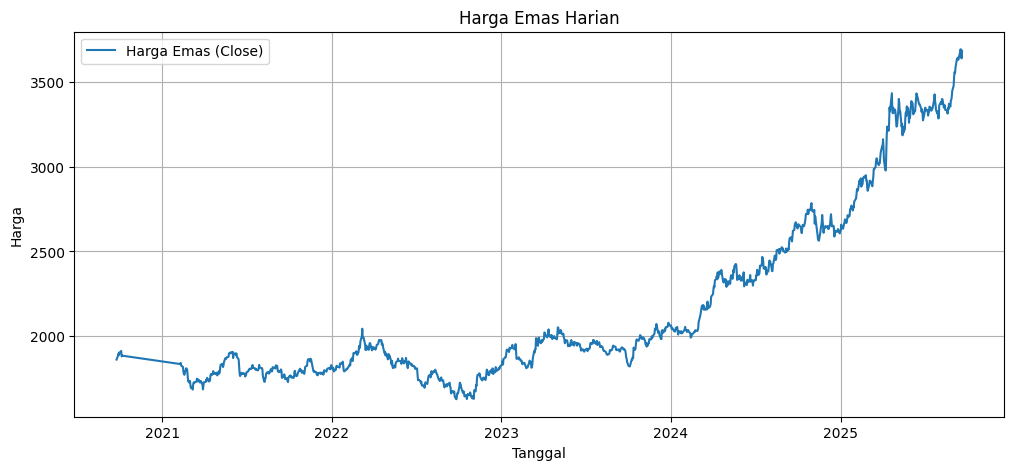

In [ ]:
# ==== 3. Plot harga emas ====
plt.figure(figsize=(12,5))
plt.plot(df["close"], label="Harga Emas (Close)")
plt.title("Harga Emas Harian")
plt.xlabel("Tanggal"); plt.ylabel("Harga"); plt.grid(True); plt.legend()
plt.show()

#Skenario 3
Model RF vs XGB vs ARIMAX

Diff + makroekonomi + importance df

In [ ]:
# ==========================================================
# ## 2. Buat Target (Y) dan Fitur (X) MINIMALIS
# ==========================================================
# Kita HANYA membuat 5 fitur yang kita yakini
# dan 1 target

def eval_model(y_true, y_pred, dataset_name=""):
    # Ubah ke array NumPy untuk menghindari error indeks
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
# 1. Buat Target (return/diff)
df['target'] = df['close'].diff()

# 2. Buat Fitur "Bersih" (WAJIB pakai .shift(1) agar tidak bocor)
df['return_lag1'] = df['target'].shift(1)
df['dxy_lag1'] = df['dxy'].shift(1)
df['vix_lag1'] = df['vix'].shift(1)
df['cpi_lag1'] = df['cpi'].shift(1)
df['oil_wti_lag1'] = df['oil_wti'].shift(1)

# 3. Buang SEMUA NaN yang dihasilkan (dari diff dan shift)
df.dropna(inplace=True)

# ==========================================================
# ## 3. Definisikan X dan Y Final
# ==========================================================

# y adalah target (return/diff)
y = df['target']

# X HANYA berisi 5 fitur bersih kita
feature_list = [
    'return_lag1',
    'dxy_lag1',
    'vix_lag1',
    'cpi_lag1',
    'oil_wti_lag1'
]
X = df[feature_list]

print(f"Data siap dengan {len(X.columns)} fitur bersih.")
print(X.head())

# ==========================================================
# ## 4. Split Data (Train & Test)
# ==========================================================
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Data latih: {len(y_train)} baris, Data uji: {len(y_test)} baris")

# ==========================================================
# ## 5. Latih Model XGBoost (dengan parameter "Bodoh")
# ==========================================================
print("\nMelatih Model XGBoost Minimalis...")

xgb_model_minimalis = XGBRegressor(
    n_estimators=100,      # Jumlah pohon sedang
    max_depth=3,           # WAJIB: Sangat dangkal
    learning_rate=0.05,
    min_child_weight=10,   # WAJIB: Butuh banyak data untuk split
    gamma=5,               # WAJIB: Regularisasi kuat
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

xgb_model_minimalis.fit(X_train, y_train)
print("Model selesai dilatih.")

# ==========================================================
# ## 6. Evaluasi JUJUR
# ==========================================================
print("\n=== Evaluasi JUJUR (Model Minimalis) ===")

# Prediksi Train (untuk cek overfitting)
y_train_pred = xgb_model_minimalis.predict(X_train)
eval_model(y_train, y_train_pred, "Train Return")

# Prediksi Test (Ini adalah hasil jujur)
y_test_pred = xgb_model_minimalis.predict(X_test)
eval_model(y_test, y_test_pred, "Test Return")

# ==========================================================
# ## 7. Cek Feature Importance (SANGAT PENTING)
# ==========================================================
print("\n=== Feature Importance (Model Minimalis) ===")
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_minimalis.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

Data siap dengan 5 fitur bersih.
   return_lag1  dxy_lag1  vix_lag1  cpi_lag1  oil_wti_lag1
2        0.540  111.7768     21.63   263.573         58.34
3        5.775  111.5929     21.99   263.573         58.69
4      -15.325  111.5364     21.25   263.573         58.22
5       -2.605  111.4981     19.97   263.573         59.50
6       -5.510  111.4981     19.97   263.573         59.50
Data latih: 984 baris, Data uji: 247 baris

Melatih Model XGBoost Minimalis...
Model selesai dilatih.

=== Evaluasi JUJUR (Model Minimalis) ===
Train Return -> MAE: 12.09, RMSE: 16.32, R²: 0.1578, MAPE: 141.46%
Test Return -> MAE: 28.60, RMSE: 41.34, R²: -0.0037, MAPE: 127.93%

=== Feature Importance (Model Minimalis) ===
        Feature  Importance
3      cpi_lag1    0.217911
0   return_lag1    0.207293
1      dxy_lag1    0.195376
2      vix_lag1    0.191669
4  oil_wti_lag1    0.187751


In [ ]:
# ==========================================================
# ## 2. Buat Target (Y) dan Fitur (X) MINIMALIS
# ==========================================================
# Kita HANYA membuat 5 fitur yang kita yakini
# dan 1 target

def eval_model(y_true, y_pred, dataset_name=""):
    # Ubah ke array NumPy untuk menghindari error indeks
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
# 1. Buat Target (return/diff)
df['target'] = df['close'].diff()

# 2. Buat Fitur "Bersih" (WAJIB pakai .shift(1) agar tidak bocor)
df['return_lag1'] = df['target'].shift(1)
df['dxy_lag1'] = df['dxy'].shift(1)
df['vix_lag1'] = df['vix'].shift(1)
df['cpi_lag1'] = df['cpi'].shift(1)
df['oil_wti_lag1'] = df['oil_wti'].shift(1)

# 3. Buang SEMUA NaN yang dihasilkan (dari diff dan shift)
df.dropna(inplace=True)

# ==========================================================
# ## 3. Definisikan X dan Y Final
# ==========================================================

# y adalah target (return/diff)
y = df['target']

# X HANYA berisi 5 fitur bersih kita
feature_list = [
    'return_lag1',
    'dxy_lag1',
    'vix_lag1',
    'cpi_lag1',
    'oil_wti_lag1'
]
X = df[feature_list]

print(f"Data siap dengan {len(X.columns)} fitur bersih.")
print(X.head())

# ==========================================================
# ## 4. Split Data (Train & Test)
# ==========================================================
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Data latih: {len(y_train)} baris, Data uji: {len(y_test)} baris")

# ==========================================================
# ## 5. Latih Model XGBoost (dengan parameter "Bodoh")
# ==========================================================
print("\nMelatih Model XGBoost Minimalis...")

rf_model_konservatif = RandomForestRegressor(
    # --- Parameter Anti-Overfitting (Paling Penting) ---

    # max_depth=3:
    # Memaksa setiap pohon untuk SANGAT DANGKAL.
    # Ini adalah cara terbaik mencegah model menghafal noise.
    max_depth=3,

    # min_samples_leaf=20:
    # Setiap "daun" (akhir keputusan) harus berisi minimal 20 data.
    # Ini mencegah model membuat aturan spesifik untuk 1-2 data aneh.
    min_samples_leaf=20,

    # --- Parameter Performa ---
    n_estimators=100,      # 100 pohon sudah lebih dari cukup
    random_state=42,       # Agar hasil Anda konsisten (bisa diulang)
    n_jobs=-1              # Gunakan semua core CPU Anda
)

rf_model_konservatif.fit(X_train, y_train)
print("Model selesai dilatih.")

# ==========================================================
# ## 6. Evaluasi JUJUR
# ==========================================================
print("\n=== Evaluasi JUJUR (Model Minimalis) ===")

# Prediksi Train (untuk cek overfitting)
y_train_pred = rf_model_konservatif.predict(X_train)
eval_model(y_train, y_train_pred, "Train Return")

# Prediksi Test (Ini adalah hasil jujur)
y_test_pred = rf_model_konservatif.predict(X_test)
eval_model(y_test, y_test_pred, "Test Return")

# ==========================================================
# ## 7. Cek Feature Importance (SANGAT PENTING)
# ==========================================================
print("\n=== Feature Importance (Model Minimalis) ===")
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_konservatif.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

Data siap dengan 5 fitur bersih.
   return_lag1  dxy_lag1  vix_lag1  cpi_lag1  oil_wti_lag1
2        0.540  111.7768     21.63   263.573         58.34
3        5.775  111.5929     21.99   263.573         58.69
4      -15.325  111.5364     21.25   263.573         58.22
5       -2.605  111.4981     19.97   263.573         59.50
6       -5.510  111.4981     19.97   263.573         59.50
Data latih: 984 baris, Data uji: 247 baris

Melatih Model XGBoost Minimalis...
Model selesai dilatih.

=== Evaluasi JUJUR (Model Minimalis) ===
Train Return -> MAE: 12.81, RMSE: 17.39, R²: 0.0440, MAPE: 124.19%
Test Return -> MAE: 28.48, RMSE: 41.37, R²: -0.0052, MAPE: 126.53%

=== Feature Importance (Model Minimalis) ===
        Feature  Importance
0   return_lag1    0.320764
1      dxy_lag1    0.208152
2      vix_lag1    0.197300
4  oil_wti_lag1    0.153545
3      cpi_lag1    0.120239


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================================
# ## 0. Fungsi Evaluasi JUJUR (Milik Anda)
# ==========================================================
def eval_model(y_true, y_pred, dataset_name=""):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Pencegahan pembagian nol yang lebih robust
    y_true_safe = np.where(np.abs(y_true) < 1e-8, 1e-8, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# 1. Buat Target (return/diff)
df['target'] = df['close'].diff()

# 2. Buat Fitur "Bersih" (WAJIB pakai .shift(1))
df['return_lag1'] = df['target'].shift(1)
df['dxy_lag1'] = df['dxy'].shift(1)
df['vix_lag1'] = df['vix'].shift(1)
df['cpi_lag1'] = df['cpi'].shift(1)
df['oil_wti_lag1'] = df['oil_wti'].shift(1)

# 3. Buang SEMUA NaN yang dihasilkan
df.dropna(inplace=True)

# ==========================================================
# ## 3. Definisikan X dan Y Final
# ==========================================================

# y adalah target (return/diff)
y = df['target']

# X HANYA berisi 5 fitur bersih kita
feature_list = [
    'return_lag1',
    'dxy_lag1',
    'vix_lag1',
    'cpi_lag1',
    'oil_wti_lag1'
]
X_exog = df[feature_list] # Kita sebut X_exog agar konsisten

print(f"Data siap dengan {len(X_exog.columns)} fitur bersih.")

# ==========================================================
# ## 4. Split Data (Train & Test)
# ==========================================================
split_idx = int(len(df) * 0.8)

X_train_exog, X_test_exog = X_exog.iloc[:split_idx], X_exog.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Data latih: {len(y_train)} baris, Data uji: {len(y_test)} baris")

# ==========================================================
# ## 5. Latih Model ARIMAX (Model Linier Murni)
# ==========================================================
print("\nMelatih Model ARIMAX Minimalis...")

arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train_exog,

    # --- KUNCI ---
    # order=(0, 0, 0):
    # Kita set p=0, d=0, q=0.
    # p=0 dan q=0: Karena kita ingin model HANYA belajar dari 'exog'.
    #              (Fitur 'return_lag1' sudah ada di 'exog' kita).
    # d=0: WAJIB, karena 'y_train' sudah di-diff.
    #
    # Ini secara efektif mengubah ARIMAX menjadi Model Regresi Linier
    # yang murni, membuatnya menjadi pembanding yang sempurna
    # untuk XGBoost (Model Non-Linier).

    order=(0, 0, 0),

    enforce_stationarity=False,
    enforce_invertibility=False
)

result = arimax_model.fit(disp=False)
print("Model selesai dilatih.")

# ==========================================================
# ## 6. Evaluasi JUJUR
# ==========================================================
print("\n=== Evaluasi JUJUR (ARIMAX Minimalis) ===")

# Prediksi Train (untuk cek overfitting)
y_train_pred = result.predict(start=0, end=len(y_train)-1, exog=X_train_exog)
eval_model(y_train, y_train_pred, "Train Return")

# Prediksi Test (Ini adalah hasil jujur)
y_test_pred = result.forecast(steps=len(y_test), exog=X_test_exog)
eval_model(y_test, y_test_pred, "Test Return")

Data siap dengan 5 fitur bersih.
Data latih: 984 baris, Data uji: 247 baris

Melatih Model ARIMAX Minimalis...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model selesai dilatih.

=== Evaluasi JUJUR (ARIMAX Minimalis) ===
Train Return -> MAE: 13.06, RMSE: 17.75, R²: 0.0036, MAPE: 123.40%
Test Return -> MAE: 28.53, RMSE: 41.38, R²: -0.0057, MAPE: 118.44%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#EXTRAS
Model RF vs XGB vs ARIMAX

Mingguan resample but w makro, L

In [ ]:
import pandas as pd
import numpy as np

# ASUMSI: df adalah DataFrame HARIAN Anda
# Pastikan 'date' adalah index datetime
df = df.set_index('date').sort_index()

# Tentukan cara agregasi untuk tiap kolom
agg_dict = {
    'open': 'first',  # Ambil harga Open hari Senin
    'high': 'max',    # Ambil harga Tertinggi selama seminggu
    'low': 'min',     # Ambil harga Terendah selama seminggu
    'close': 'last',  # Ambil harga Close hari Jumat
    'dxy': 'mean',
    'vix': 'mean',
    'cpi': 'last',
    'oil_wti': 'mean',
    # (Tambahkan kolom lain jika ada)
}

# 'W' = Mingguan (berakhir hari Minggu). 'W-FRI' juga bisa (berakhir Jumat)
df_weekly = df.resample('W').agg(agg_dict)

# Hapus minggu-minggu di mana data tidak lengkap (misal: libur)
df_weekly.dropna(inplace=True)

print("Data harian berhasil diubah ke mingguan:")
print(df_weekly.head())

Data harian berhasil diubah ke mingguan:
                open      high       low     close        dxy     vix  \
date                                                                    
2021-02-14  1830.530  1855.420  1810.670  1824.255  111.69108  21.216   
2021-02-21  1821.130  1827.185  1760.670  1783.980  111.84324  21.494   
2021-02-28  1783.520  1816.145  1717.315  1734.365  112.07200  24.948   
2021-03-07  1739.265  1759.825  1687.440  1700.570  112.86818  25.470   
2021-03-14  1707.770  1739.885  1676.810  1726.825  113.56036  22.932   

                cpi  oil_wti  
date                          
2021-02-14  263.573   58.540  
2021-02-21  263.573   60.036  
2021-02-28  263.573   62.304  
2021-03-07  264.847   62.292  
2021-03-14  264.847   65.022  


In [ ]:
# === 1. Buat Target (Y) MINGGUAN ===
# Ini adalah return/diff MINGGUAN
df_weekly['target'] = df_weekly['close'].diff()

# === 2. Buat Fitur (X) MINGGUAN (ANTI-LEAKAGE) ===

# --- Fitur Lag (1 minggu lalu, 2 minggu lalu) ---

df_weekly['return_lag1'] = df_weekly['target'].shift(1)
df_weekly['dxy_lag1'] = df_weekly['dxy'].shift(1)
df_weekly['cpi_lag1'] = df_weekly['cpi'].shift(1)
# Corrected: Create the lagged feature on the weekly DataFrame
df_weekly['oil_wti_lag1'] = df_weekly['oil_wti'].shift(1)
df_weekly['vix_lag1'] = df_weekly['vix'].shift(1)
df_weekly['close_lag1'] = df_weekly['close'].shift(1)


# --- Fitur Lag (dari O,H,L,C dan DXY) ---
# Ini adalah fitur yang Anda tanyakan:
# feature_cols = ['open', 'high', 'low', 'close', 'dxy']
# lags = [1, 2, 3, 4] # Ini adalah lag 1, 2, 3, 4 MINGGU

# for col in feature_cols:
#     for lag in lags:
#         df_weekly[f'{col}_lag{lag}'] = df_weekly[col].shift(lag)
# (Tambahkan lag lain jika perlu)

# # --- Fitur MA (Moving Averages MINGGUAN) ---
# # MA 4-minggu (tren 1 bulan), MA 12-minggu (tren 3 bulan)
# df_weekly['ma_4'] = df_weekly['close'].shift(1).rolling(window=4).mean()
# df_weekly['ma_12'] = df_weekly['close'].shift(1).rolling(window=12).mean()

# # --- Fitur Volatilitas MINGGUAN ---
# df_weekly['vol_4'] = df_weekly['target'].shift(1).rolling(window=4).std()


# === 3. Bersihkan dan Definisikan X & Y Final ===
df_weekly.dropna(inplace=True)

y = df_weekly['target']

# X berisi SEMUA fitur lag
feature_list = [
    'return_lag1',
    'dxy_lag1',
    'vix_lag1',
    'cpi_lag1',
    'oil_wti_lag1'
]
X = df_weekly[feature_list]

In [ ]:
import numpy as np  # <-- PERBAIKAN 1: Import numpy
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# (Kode split data Anda)
split_idx = int(len(df_weekly) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

y_train_actual_prices = df_weekly['close'].iloc[:split_idx]
y_test_actual_prices = df_weekly['close'].iloc[split_idx:]

# (Kode model XGB)
xgb_model = XGBRegressor(
    # objective='reg:squarederror',
    # n_estimators=150,
    # max_depth=3,
    # learning_rate=0.1,
    # subsample=0.8,
    # colsample_bytree=0.8,
    # reg_lambda=1,
    # random_state=42
    objective='reg:squarederror',

    # === Parameter Paling Penting untuk Diubah ===
    max_depth=1,            # Paksa model jadi 'decision stump'. Sangat dangkal.
    learning_rate=0.01,     # Paksa belajar JAUH LEBIH PELAN.
    n_estimators=50,        # Lebih sedikit pohon, lebih sedikit kesempatan menghafal.
    reg_lambda=5,           # Tingkatkan 'hukuman' regularisasi L2 secara signifikan.
    min_child_weight=10,    # Paksa setiap 'leaf' butuh minimal 10 sampel.
    # ===============================================

    subsample=0.7,          # Kurangi lagi subsample
    colsample_bytree=0.7,   # Kurangi lagi colsample
    random_state=42

)
xgb_model.fit(X_train, y_train)

# ==== 6. Prediksi dan Evaluasi ====
# Fungsi evaluasi (sekarang 'np' sudah didefinisikan)
def eval_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

print("=== Evaluasi pada Prediksi Harga Absolut ===")

# --- Evaluasi pada Data Latih ---
y_train_pred_diffs = xgb_model.predict(X_train)
last_prices_train = df_weekly['close_lag1'].iloc[:split_idx]
# PERBAIKAN 2: Gunakan .values untuk menghindari error index alignment
predicted_prices_train = last_prices_train.values + y_train_pred_diffs
eval_model(y_train_actual_prices, predicted_prices_train, "Train")

# --- Evaluasi pada Data Uji ---
y_test_pred_diffs = xgb_model.predict(X_test)
last_prices_test = df_weekly['close_lag1'].iloc[split_idx:]
# PERBAIKAN 2: Gunakan .values untuk menghindari error index alignment
predicted_prices_test = last_prices_test.values + y_test_pred_diffs
eval_model(y_test_actual_prices, predicted_prices_test, "Test")

# === Evaluasi JUJUR pada Prediksi Return/Diff ===
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")
# Bagian ini sudah benar dari awal
eval_model(y_train, y_train_pred_diffs, "Train Return")
eval_model(y_test, y_test_pred_diffs, "Test Return")

=== Evaluasi pada Prediksi Harga Absolut ===
Train -> MAE: 28.75, RMSE: 38.45, R²: 0.9782, MAPE: 1.45%
Test -> MAE: 64.12, RMSE: 81.41, R²: 0.9630, MAPE: 1.91%

=== Evaluasi JUJUR pada Prediksi Return/Diff ===
Train Return -> MAE: 28.75, RMSE: 38.45, R²: 0.0231, MAPE: 117.11%
Test Return -> MAE: 64.12, RMSE: 81.41, R²: -0.0648, MAPE: 155.21%


In [ ]:
import numpy as np  # <-- PERBAIKAN 1: Import numpy
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# (Kode split data Anda)
split_idx = int(len(df_weekly) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

y_train_actual_prices = df_weekly['close'].iloc[:split_idx]
y_test_actual_prices = df_weekly['close'].iloc[split_idx:]

# (Kode model XGB)
xgb_model = XGBRegressor(
    # objective='reg:squarederror',
    # n_estimators=150,
    # max_depth=3,
    # learning_rate=0.1,
    # subsample=0.8,
    # colsample_bytree=0.8,
    # reg_lambda=1,
    # random_state=42
    objective='reg:squarederror',

    # === Parameter Paling Penting untuk Diubah ===
    max_depth=1,            # Paksa model jadi 'decision stump'. Sangat dangkal.
    learning_rate=0.01,     # Paksa belajar JAUH LEBIH PELAN.
    n_estimators=50,        # Lebih sedikit pohon, lebih sedikit kesempatan menghafal.
    reg_lambda=5,           # Tingkatkan 'hukuman' regularisasi L2 secara signifikan.
    min_child_weight=10,    # Paksa setiap 'leaf' butuh minimal 10 sampel.
    # ===============================================

    subsample=0.7,          # Kurangi lagi subsample
    colsample_bytree=0.7,   # Kurangi lagi colsample
    random_state=42

)
xgb_model.fit(X_train, y_train)

# ==== 6. Prediksi dan Evaluasi ====
# Fungsi evaluasi (sekarang 'np' sudah didefinisikan)
def eval_model(y_true, y_pred, dataset_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{dataset_name} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

print("=== Evaluasi pada Prediksi Harga Absolut ===")

# --- Evaluasi pada Data Latih ---
y_train_pred_diffs = xgb_model.predict(X_train)
last_prices_train = df_weekly['close_lag1'].iloc[:split_idx]
# PERBAIKAN 2: Gunakan .values untuk menghindari error index alignment
predicted_prices_train = last_prices_train.values + y_train_pred_diffs
eval_model(y_train_actual_prices, predicted_prices_train, "Train")

# --- Evaluasi pada Data Uji ---
y_test_pred_diffs = xgb_model.predict(X_test)
last_prices_test = df_weekly['close_lag1'].iloc[split_idx:]
# PERBAIKAN 2: Gunakan .values untuk menghindari error index alignment
predicted_prices_test = last_prices_test.values + y_test_pred_diffs
eval_model(y_test_actual_prices, predicted_prices_test, "Test")

# === Evaluasi JUJUR pada Prediksi Return/Diff ===
print("\n=== Evaluasi JUJUR pada Prediksi Return/Diff ===")
# Bagian ini sudah benar dari awal
eval_model(y_train, y_train_pred_diffs, "Train Return")
eval_model(y_test, y_test_pred_diffs, "Test Return")

In [ ]:
# ==========================================================
# ## 7. Cek Feature Importance (SANGAT PENTING)
# ==========================================================
print("\n=== Feature Importance (Model Minimalis) ===")
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)


=== Feature Importance (Model Minimalis) ===
        Feature  Importance
3      cpi_lag1    0.238357
1      dxy_lag1    0.236686
4  oil_wti_lag1    0.189869
0   return_lag1    0.172513
2      vix_lag1    0.162576


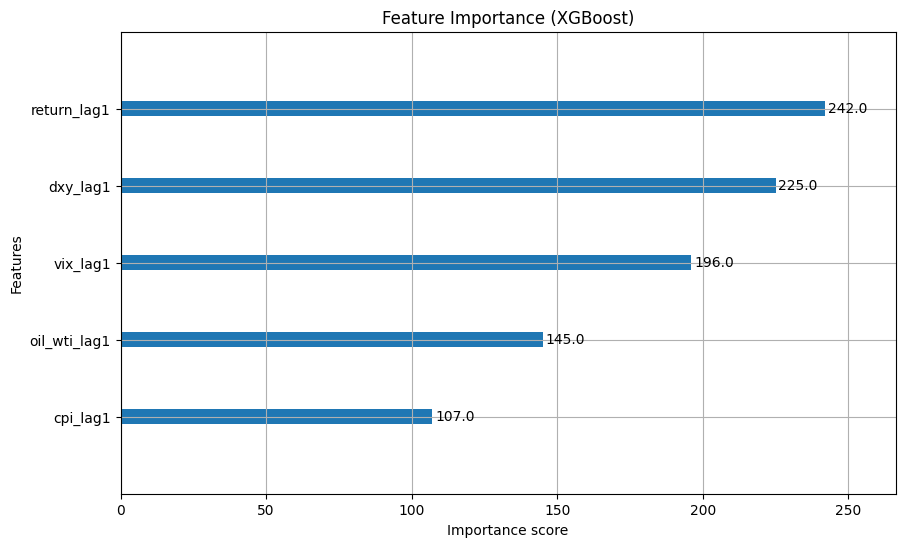

In [ ]:
# Coba jalankan ini:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(xgb_model, ax=ax, max_num_features=10)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [ ]:
df

,open,high,low,close,dxy,target,return_lag1,return_lag2,return_lag3,return_lag7,...,low_lag7,low_lag14,close_lag1,close_lag3,close_lag7,close_lag14,dxy_lag1,dxy_lag3,dxy_lag7,dxy_lag14
date,,,,,,,,,,,,,,,,,,,,,
2021-02-12,1826.845,1830.790,1810.670,1824.255,111.4981,-5.510,-2.605,-15.325,5.775,6.790,...,1874.890,1852.40,1826.860,1836.410,1880.27,1861.74,111.5364,111.7768,116.2781,117.8786
2021-02-15,1821.130,1827.185,1816.135,1818.745,111.4981,-30.195,-5.510,-2.605,-15.325,-2.460,...,1872.980,1848.56,1824.255,1842.185,1887.06,1882.85,111.4981,111.5929,116.3548,117.6290
2021-02-16,1818.740,1826.410,1787.070,1788.550,111.7984,-10.300,-30.195,-5.510,-2.605,-48.730,...,1883.470,1875.57,1818.745,1826.860,1884.60,1897.06,111.4981,111.5364,116.1753,117.5379
2021-02-17,1788.545,1795.285,1769.615,1778.250,112.0300,-6.430,-10.300,-30.195,-5.510,0.540,...,1828.965,1881.49,1788.550,1824.255,1835.87,1888.34,111.7984,111.4981,112.0512,116.9570
2021-02-18,1778.260,1789.615,1768.430,1771.820,112.1718,12.160,-6.430,-10.300,-30.195,5.775,...,1832.310,1884.77,1778.250,1818.745,1836.41,1903.54,112.0300,111.4981,111.7768,116.7339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-12,3631.870,3656.700,3630.630,3643.610,120.4905,33.390,11.750,-13.080,11.320,-7.690,...,3527.060,3351.79,3631.860,3633.620,3560.37,3354.95,120.3810,120.5746,120.9032,120.8298
2025-09-15,3638.280,3685.650,3626.750,3677.000,120.0042,17.310,33.390,11.750,-13.080,34.050,...,3511.370,3351.34,3643.610,3644.940,3552.68,3390.97,120.4905,120.5447,121.1565,120.9304
2025-09-16,3676.950,3703.260,3674.760,3694.310,119.5860,-25.070,17.310,33.390,11.750,48.340,...,3544.940,3373.89,3677.000,3631.860,3586.73,3395.84,120.0042,120.3810,120.5394,121.1236


#Skenario 4
Model RF vs XGB vs ARIMAX
MA3

smoothed target MA3 Hybrid vs ARIMAX

In [ ]:
df = df.set_index('date').sort_index()

# target: MA(3) besok (boleh ganti 5 kalau mau lebih halus)
df['ma3'] = df['close'].rolling(3).mean()
df['target'] = df['ma3'].shift(-1)


In [ ]:
feature_cols = ['close', 'dxy']   # bisa tambah open/high/low juga

lags = [1, 3, 7, 14]
for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df = df.dropna()

y = df['target']
X_exog = df.drop(columns=['target', 'ma3', 'close', 'dxy'])


In [ ]:
split_idx = int(len(df) * 0.8)

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

X_train_exog = X_exog.iloc[:split_idx]
X_test_exog  = X_exog.iloc[split_idx:]


In [ ]:
naive_train = df['ma3'].iloc[:split_idx]
naive_test  = df['ma3'].iloc[split_idx:]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train_exog,
    order=(1, 0, 1),   # MA sudah halus, d bisa 0 dulu
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_result = arimax_model.fit(disp=False)

y_pred_arimax_train = arimax_result.predict(
    start=0,
    end=len(y_train)-1,
    exog=X_train_exog
)

y_pred_arimax_test = arimax_result.predict(
    start=len(y_train),
    end=len(y_train) + len(y_test) - 1,
    exog=X_test_exog
)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
from xgboost import XGBRegressor

residuals_train = y_train - y_pred_arimax_train

xgb_model_resid = XGBRegressor(
    # === Parameter Konservatif untuk Mencegah Overfit ===

    # Kurangi jumlah pohon
    n_estimators=100,

    # Tambahkan learning rate untuk memperlambat proses belajar
    learning_rate=0.1,

    # max_depth=3 sudah bagus
    max_depth=3,

    # Paksa setiap 'leaf' butuh lebih banyak sampel (naikkan dari 5)
    min_child_weight=10,

    # === Ini Perubahan Paling Penting ===
    # Tambahkan lebih banyak keacakan (turunkan dari 0.9)
    subsample=0.7,
    colsample_bytree=0.7,

    # Tambahkan sedikit regularisasi L2
    reg_lambda=1,
    # ==================================================

    random_state=42,
    n_jobs=-1
)
xgb_model_resid.fit(X_train_exog, residuals_train)

resid_pred_train = xgb_model_resid.predict(X_train_exog)
resid_pred_test  = xgb_model_resid.predict(X_test_exog)

final_pred_train = y_pred_arimax_train + resid_pred_train
final_pred_test  = y_pred_arimax_test + resid_pred_test


In [ ]:
def eval_model(y_true, y_pred, name=""):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    print(f"{name:25s} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

print("\n=== Evaluasi Target = MA3 Besok ===")
eval_model(y_train, naive_train,         "Naive (Train)")
eval_model(y_test,  naive_test,          "Naive (Test)")

eval_model(y_train, y_pred_arimax_train, "ARIMAX Only (Train)")
eval_model(y_test,  y_pred_arimax_test,  "ARIMAX Only (Test)")

eval_model(y_train, final_pred_train,    "Hybrid ARIMAX+XGB (Train)")
eval_model(y_test,  final_pred_test,     "Hybrid ARIMAX+XGB (Test)")



=== Evaluasi Target = MA3 Besok ===
Naive (Train)             -> MAE: 7.37, RMSE: 9.63, R²: 0.9983, MAPE: 0.38%
Naive (Test)              -> MAE: 15.24, RMSE: 20.05, R²: 0.9960, MAPE: 0.49%
ARIMAX Only (Train)       -> MAE: 5.30, RMSE: 6.92, R²: 0.9991, MAPE: 0.27%
ARIMAX Only (Test)        -> MAE: 10.23, RMSE: 13.19, R²: 0.9983, MAPE: 0.33%
Hybrid ARIMAX+XGB (Train) -> MAE: 4.39, RMSE: 5.70, R²: 0.9994, MAPE: 0.23%
Hybrid ARIMAX+XGB (Test)  -> MAE: 10.37, RMSE: 13.39, R²: 0.9982, MAPE: 0.34%


Arimax vs XGB vs RF

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Fungsi evaluasi
# ==========================
def eval_model(y_true, y_pred, name=""):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    print(f"{name:25s} -> MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# ==========================
# 0. Data awal
# ==========================
# df harus minimal: ['date','close','dxy', ...]
df = df.set_index('date').sort_index()

# 🎯 TARGET: MA(3) besok (Option B)
df['ma3'] = df['close'].rolling(3).mean()
df['target'] = df['ma3'].shift(-1)

# fitur dasar (boleh kamu tambah):
feature_cols = ['close', 'dxy']
lags = [1, 3, 7, 14]

for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# contoh: tambah indikator lain kalau mau
# df['close_ma5'] = df['close'].rolling(5).mean()
# df['close_std5'] = df['close'].rolling(5).std()

df = df.dropna()

y = df['target']
X = df.drop(columns=[
    'target',
    'ma3',
    'close', 'dxy'    # kita pakai lags / indikator aja buat fitur
])

print("Shape X:", X.shape)


Shape X: (1193, 11)


In [ ]:
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# baseline: prediksi MA3 besok = MA3 hari ini
naive_train = df['ma3'].iloc[:split_idx]
naive_test  = df['ma3'].iloc[split_idx:]

print(f"Train: {len(y_train)}, Test: {len(y_test)}")


Train: 954, Test: 239


In [ ]:
print("\n=== ARIMAX (MA3 target) ===")
arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),   # MA3 sudah halus → d=0 cukup
    enforce_stationarity=False,
    enforce_invertibility=False,
)
arimax_res = arimax_model.fit(disp=False)

# in-sample
y_pred_arimax_train = arimax_res.fittedvalues
y_pred_arimax_train = y_pred_arimax_train.loc[y_train.index]

# out-of-sample
y_pred_arimax_test = arimax_res.forecast(
    steps=len(y_test),
    exog=X_test
)
y_pred_arimax_test.index = y_test.index

eval_model(y_train, naive_train,        "Naive (Train)")
eval_model(y_test,  naive_test,         "Naive (Test)")
eval_model(y_train, y_pred_arimax_train,"ARIMAX (Train)")
eval_model(y_test,  y_pred_arimax_test, "ARIMAX (Test)")



=== ARIMAX (MA3 target) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Naive (Train)             -> MAE: 7.37, RMSE: 9.63, R²: 0.9983, MAPE: 0.38%
Naive (Test)              -> MAE: 15.24, RMSE: 20.05, R²: 0.9960, MAPE: 0.49%
ARIMAX (Train)            -> MAE: 5.30, RMSE: 6.92, R²: 0.9991, MAPE: 0.27%
ARIMAX (Test)             -> MAE: 10.23, RMSE: 13.19, R²: 0.9983, MAPE: 0.33%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
print("\n=== XGBoost (MA3 target) ===")
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=5,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test  = xgb_model.predict(X_test)

eval_model(y_train, y_pred_xgb_train, "XGB (Train)")
eval_model(y_test,  y_pred_xgb_test,  "XGB (Test)")



=== XGBoost (MA3 target) ===
XGB (Train)               -> MAE: 3.89, RMSE: 5.15, R²: 0.9995, MAPE: 0.20%
XGB (Test)                -> MAE: 403.41, RMSE: 508.60, R²: -1.5474, MAPE: 12.23%


In [ ]:
print("\n=== Random Forest (MA3 target) ===")
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test  = rf_model.predict(X_test)

eval_model(y_train, y_pred_rf_train, "RF (Train)")
eval_model(y_test,  y_pred_rf_test,  "RF (Test)")



=== Random Forest (MA3 target) ===
RF (Train)                -> MAE: 4.56, RMSE: 5.99, R²: 0.9993, MAPE: 0.24%
RF (Test)                 -> MAE: 405.04, RMSE: 508.82, R²: -1.5496, MAPE: 12.29%


#Skenario 5
Model RF vs XGB vs ARIMAX

DUL DUL DUL
delta MA3

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Fungsi evaluasi (tanpa MAPE)
# -------------------------
def eval_model(y_true, y_pred, name=""):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:20s} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# -------------------------
# 0. Data awal
# df harus punya: ['date','close','dxy', ...]
# -------------------------
df = df.set_index('date').sort_index()

# MA3 (tren halus)
df['ma3'] = df['close'].rolling(3).mean()

# 🎯 TARGET: ΔMA3 = MA3_{t+1} - MA3_t
df['target'] = df['ma3'].shift(-1) - df['ma3']

# Fitur: lag dari close, ma3, dxy (bisa tambah lain kalau mau)
feature_cols = ['close', 'ma3', 'dxy']
lags = [1, 3, 7, 14]

for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df = df.dropna()

y = df['target']
X = df.drop(columns=['target', 'ma3', 'close', 'dxy'])  # cuma pakai lag2 sebagai fitur

print("Shape X:", X.shape)


Shape X: (1191, 15)


In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations']
    print(f'ADF Test: {title}')
    for value, label in zip(result[0:4], labels):
        print(f'{label} : {value}')
    if result[1] <= 0.05:
        print("✅ Data stasioner (tolak H0)")
    else:
        print("❌ Data tidak stasioner (gagal tolak H0)")
    print('----------------------------------')

adf_test(df["target"], "Harga Emas (delta MA3)")


In [ ]:
from statsmodels.tsa.stattools import adfuller

def find_optimal_d(series, max_d=3):
    for d in range(max_d+1):
        test_series = series.diff(d).dropna() if d > 0 else series
        p_value = adfuller(test_series)[1]
        print(f"d={d}, p-value={p_value:.4f}")
        if p_value <= 0.05:
            print(f"✅ Data stasioner pada d={d}")
            return d
    print("❌ Data belum stasioner hingga d maksimum.")
    return max_d

d_optimal = find_optimal_d(df["target"])


In [ ]:
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train: {len(y_train)}, Test: {len(y_test)}")

# Naive: ΔMA3 besok = 0 (MA3 besok sama dengan hari ini)
naive_train = np.zeros_like(y_train)
naive_test  = np.zeros_like(y_test)


Train: 952, Test: 239


In [ ]:
print("\n=== ARIMAX (ΔMA3 target) ===")

arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),          # d=0 karena target sudah 'delta'
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_res = arimax_model.fit(disp=False)

# in-sample
y_pred_arimax_train = arimax_res.fittedvalues
y_pred_arimax_train = y_pred_arimax_train.loc[y_train.index]

# out-of-sample
y_pred_arimax_test = arimax_res.forecast(
    steps=len(y_test),
    exog=X_test
)
y_pred_arimax_test.index = y_test.index

eval_model(y_train, naive_train,         "Naive (Train)")
eval_model(y_test,  naive_test,          "Naive (Test)")
eval_model(y_train, y_pred_arimax_train, "ARIMAX (Train)")
eval_model(y_test,  y_pred_arimax_test,  "ARIMAX (Test)")



=== ARIMAX (ΔMA3 target) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Naive (Train)        -> MAE: 7.3656, RMSE: 9.6277, R²: -0.0094
Naive (Test)         -> MAE: 15.2398, RMSE: 20.0471, R²: -0.0426
ARIMAX (Train)       -> MAE: 4.4493, RMSE: 5.8958, R²: 0.6215
ARIMAX (Test)        -> MAE: 8.9932, RMSE: 11.7617, R²: 0.6411


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# MA3 actual hari ini
ma3_today = df['ma3'].iloc[-1]

# ambil prediksi delta untuk besok
delta_pred = final_prediction[-1]   # ganti sesuai nama variable

# MA3 prediksi besok
ma3_pred_tomorrow = ma3_today + delta_pred

# ambil harga close(t) dan close(t-1)
close_t   = df['close'].iloc[-1]
close_tm1 = df['close'].iloc[-2]

# rekonstruksi harga absolut
close_pred_tomorrow = 3 * ma3_pred_tomorrow - close_t - close_tm1

print("Prediksi harga emas (close) besok:", close_pred_tomorrow)

In [ ]:
df_pred = df.copy()

df_pred['ma3_pred'] = df_pred['ma3']
df_pred.iloc[-1, df_pred.columns.get_loc('ma3_pred')] = ma3_pred_tomorrow

df_pred['close_pred'] = df_pred['close']
df_pred.iloc[-1, df_pred.columns.get_loc('close_pred')] = close_pred_tomorrow

plt.figure(figsize=(12,5))
plt.plot(df_pred['close'], label='Actual Close')
plt.plot(df_pred['close_pred'], label='Predicted Close (Reconstructed)')
plt.legend()
plt.title("Actual vs Predicted Gold Price")
plt.grid(True)
plt.show()


In [ ]:
print("\n=== XGBoost (ΔMA3 target) ===")

xgb_model = XGBRegressor(
    # === Parameter SANGAT KETAT untuk Memaksa Kejujuran ===

    # Kurangi lagi pohonnya
    n_estimators=75,

    # PERLAMBAT proses belajar secara drastis
    learning_rate=0.05,

    # Paksa pohon jadi SANGAT dangkal
    max_depth=2,

    # NAIKKAN: Paksa setiap 'leaf' mewakili grup yang lebih besar
    min_child_weight=20,

    # NAIKKAN: Tambah hukuman regularisasi L2
    reg_lambda=5,

    # TURUNKAN: Tambah lebih banyak keacakan
    subsample=0.6,
    colsample_bytree=0.6,

    # =====================================================

    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test  = xgb_model.predict(X_test)

eval_model(y_train, y_pred_xgb_train, "XGB (Train)")
eval_model(y_test,  y_pred_xgb_test,  "XGB (Test)")



=== XGBoost (ΔMA3 target) ===
XGB (Train)          -> MAE: 6.6537, RMSE: 8.6024, R²: 0.1941
XGB (Test)           -> MAE: 14.9844, RMSE: 19.6526, R²: -0.0019


In [ ]:
print("\n=== Random Forest (ΔMA3 target) ===")

rf_model = RandomForestRegressor(
    # === Parameter Konservatif ===

    # Kurangi jumlah pohon, 300 itu terlalu banyak untuk awal
    n_estimators=150,

    # PENTING: Batasi kedalaman pohon
    max_depth=3,

    # PENTING: Paksa model butuh lebih banyak sampel untuk membelah
    min_samples_split=10,

    # PENTING: Paksa setiap 'daun' (prediksi akhir) mewakili lebih banyak sampel
    min_samples_leaf=10,

    # TAMBAHAN: Paksa model hanya melihat 80% fitur di setiap pohon
    max_features=0.8,

    # ============================

    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test  = rf_model.predict(X_test)

eval_model(y_train, y_pred_rf_train, "RF (Train)")
eval_model(y_test,  y_pred_rf_test,  "RF (Test)")



=== Random Forest (ΔMA3 target) ===
RF (Train)           -> MAE: 6.7419, RMSE: 8.7107, R²: 0.1737
RF (Test)            -> MAE: 14.9883, RMSE: 19.6714, R²: -0.0039


#EXTRAS
Model RF vs XGB vs ARIMAX

ewm

In [ ]:
df = df.set_index('date').sort_index()

# EWM smoothing
df['ewm3'] = df['close'].ewm(span=3, adjust=False).mean()

# Target = EWM3 besok
df['target'] = df['ewm3'].shift(-1)


In [ ]:
feature_cols = ['close', 'ewm3', 'dxy']
lags = [1, 3, 7, 14]

for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

df = df.dropna()

y = df['target']
X = df.drop(columns=['target', 'ewm3', 'close', 'dxy'])


In [ ]:
split_idx = int(len(df)*0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Naive baseline = EWM hari ini
naive_train = df['ewm3'].iloc[:split_idx]
naive_test  = df['ewm3'].iloc[split_idx:]


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_model(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:20s} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("\n=== ARIMAX (EWM3 target) ===")

arimax = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1,0,1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

y_pred_arimax_train = arimax.fittedvalues
y_pred_arimax_train = y_pred_arimax_train.loc[y_train.index]

y_pred_arimax_test = arimax.forecast(steps=len(y_test), exog=X_test)
y_pred_arimax_test.index = y_test.index

eval_model(y_train, naive_train, "Naive (Train)")
eval_model(y_test,  naive_test,  "Naive (Test)")
eval_model(y_train, y_pred_arimax_train, "ARIMAX (Train)")
eval_model(y_test,  y_pred_arimax_test,  "ARIMAX (Test)")



=== ARIMAX (EWM3 target) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Naive (Train)        -> MAE: 7.3386, RMSE: 9.7681, R²: 0.9982
Naive (Test)         -> MAE: 14.8557, RMSE: 19.6662, R²: 0.9962
ARIMAX (Train)       -> MAE: 6.3649, RMSE: 8.4714, R²: 0.9987
ARIMAX (Test)        -> MAE: 26.1853, RMSE: 33.9399, R²: 0.9886


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
from xgboost import XGBRegressor

print("\n=== XGBoost (EWM3 target) ===")

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=5,
    random_state=42
)

xgb.fit(X_train, y_train)

eval_model(y_train, xgb.predict(X_train), "XGB (Train)")
eval_model(y_test,  xgb.predict(X_test),  "XGB (Test)")



=== XGBoost (EWM3 target) ===
XGB (Train)          -> MAE: 5.2974, RMSE: 6.9085, R²: 0.9991
XGB (Test)           -> MAE: 405.4013, RMSE: 509.2372, R²: -1.5595


In [ ]:
from sklearn.ensemble import RandomForestRegressor

print("\n=== Random Forest (EWM3 target) ===")

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

eval_model(y_train, rf.predict(X_train), "RF (Train)")
eval_model(y_test,  rf.predict(X_test),  "RF (Test)")



=== Random Forest (EWM3 target) ===
RF (Train)           -> MAE: 6.1202, RMSE: 8.0424, R²: 0.9988
RF (Test)            -> MAE: 406.6190, RMSE: 510.2117, R²: -1.5693


FINAL VERDICT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Fungsi evaluasi (tanpa MAPE)
# -------------------------
def eval_model(y_true, y_pred, name=""):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name:20s} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


# ==========================================================
# 0. Data awal
# df harus punya kolom: ['date','close','dxy', ...]
# ==========================================================
df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# MA3 (tren halus)
df['ma3'] = df['close'].rolling(3).mean()

# 🎯 TARGET: ΔMA3 = MA3_{t+1} - MA3_t
df['target'] = df['ma3'].shift(-1) - df['ma3']

# Fitur: lag dari close, ma3, dxy (bisa tambah lain kalau mau)
feature_cols = ['close', 'ma3', 'dxy']
lags = [1, 3, 7, 14]

for col in feature_cols:
    for lag in lags:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# buang NaN akibat rolling & lag
df = df.dropna()

# y = ΔMA3, X = fitur-fitur lag
y = df['target']
X = df.drop(columns=['target', 'ma3', 'close', 'dxy'])  # cuma pakai lag2 sebagai fitur

print("Shape X:", X.shape)

Shape X: (1191, 15)


In [ ]:
# ==========================================================
# 1. Train–Test Split
# ==========================================================
split_idx = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train: {len(y_train)}, Test: {len(y_test)}")

# Naive: ΔMA3 besok = 0 (MA3 besok sama dengan hari ini)
naive_train = np.zeros_like(y_train)
naive_test  = np.zeros_like(y_test)


Train: 952, Test: 239


In [ ]:
# ==========================================================
# 2. ARIMAX (ΔMA3 target)
# ==========================================================
print("\n=== ARIMAX (ΔMA3 target) ===")

arimax_model = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),          # d=0 karena target sudah 'delta'
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_res = arimax_model.fit(disp=False)

# in-sample
y_pred_arimax_train = arimax_res.fittedvalues
y_pred_arimax_train = y_pred_arimax_train.loc[y_train.index]

# out-of-sample
y_pred_arimax_test = arimax_res.forecast(
    steps=len(y_test),
    exog=X_test
)
y_pred_arimax_test.index = y_test.index

# evaluasi ΔMA3
eval_model(y_train, naive_train,         "Naive (Train)")
eval_model(y_test,  naive_test,          "Naive (Test)")
eval_model(y_train, y_pred_arimax_train, "ARIMAX (Train)")
eval_model(y_test,  y_pred_arimax_test,  "ARIMAX (Test)")


=== ARIMAX (ΔMA3 target) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Naive (Train)        -> MAE: 7.3656, RMSE: 9.6277, R²: -0.0094
Naive (Test)         -> MAE: 15.2398, RMSE: 20.0471, R²: -0.0426
ARIMAX (Train)       -> MAE: 4.4493, RMSE: 5.8958, R²: 0.6215
ARIMAX (Test)        -> MAE: 8.9932, RMSE: 11.7617, R²: 0.6411


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
# ==========================================================
# 3. Rekonstruksi MA3 & Harga Absolut dari ΔMA3 Prediksi
#    (supaya nyambung sama judul "prediksi harga emas")
# ==========================================================

# ambil MA3 actual hari terakhir (MA3_t)
ma3_today = df['ma3'].iloc[-1]

# ambil prediksi delta untuk hari terakhir di test (ΔMA3_t)
# ini prediksi perubahan MA3 dari hari terakhir → hari besok
delta_pred = y_pred_arimax_test.iloc[-1]

# MA3 prediksi besok: MA3_{t+1} = MA3_t + ΔMA3_t
ma3_pred_tomorrow = ma3_today + delta_pred

# ambil harga close(t) dan close(t-1)
close_t   = df['close'].iloc[-1]
close_tm1 = df['close'].iloc[-2]

# rekonstruksi harga absolut besok:
# MA3_{t+1} = (close_{t+1} + close_t + close_{t-1}) / 3
# => close_{t+1} = 3*MA3_{t+1} - close_t - close_{t-1}
close_pred_tomorrow = 3 * ma3_pred_tomorrow - close_t - close_tm1

print("\nPrediksi harga emas (close) besok:", close_pred_tomorrow)


Prediksi harga emas (close) besok: 3649.461504065881


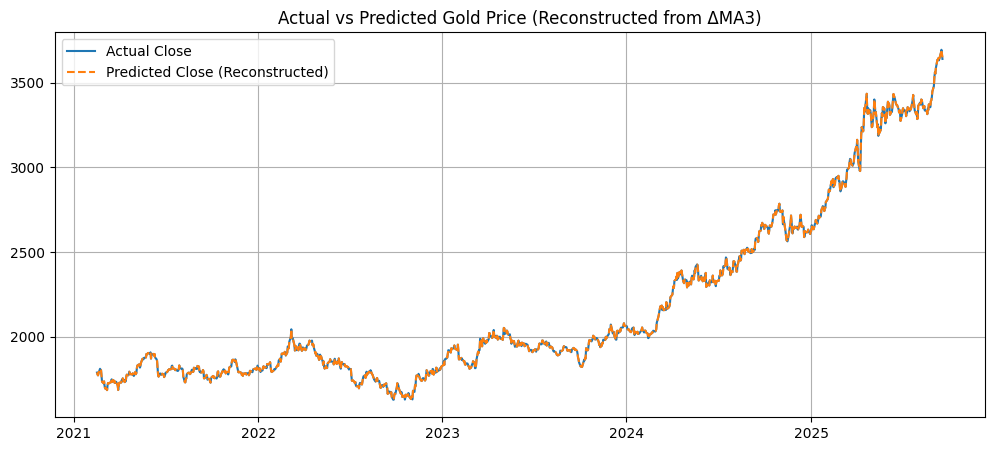

In [ ]:
# ==========================================================
# 4. Buat DataFrame Prediksi untuk Visualisasi
# ==========================================================
df_pred = df.copy()

# kolom MA3 prediksi (isi sama seperti MA3 actual, kecuali baris terakhir)
df_pred['ma3_pred'] = df_pred['ma3']
df_pred.iloc[-1, df_pred.columns.get_loc('ma3_pred')] = ma3_pred_tomorrow

# kolom harga prediksi (sama seperti close, kecuali baris terakhir)
df_pred['close_pred'] = df_pred['close']
df_pred.iloc[-1, df_pred.columns.get_loc('close_pred')] = close_pred_tomorrow

# plot harga actual vs harga prediksi (hanya titik terakhir beda)
plt.figure(figsize=(12, 5))
plt.plot(df_pred['close'], label='Actual Close')
plt.plot(df_pred['close_pred'], label='Predicted Close (Reconstructed)', linestyle='--')
plt.legend()
plt.title("Actual vs Predicted Gold Price (Reconstructed from ΔMA3)")
plt.grid(True)
plt.show()